# Customizing the Qiskit compiler

In yesterday's workshop we covered how the built-in options to Qiskit's `transpile()` function and how using it can impact the output and performance of running quantum circuits. Today we're going to be look at how we can augment the compilation outside of what is built-in to `transpile()`.

In [1]:
import qiskit
qiskit.__version__

'0.23.3'

## Transpiler Composition

### Building custom pipelines with: `StagedPassManager`

Building on top of the `PassManager` class is the `StagedPassManager` which adds a concept of stages to group position of the passes which are run (the data structure which manages the pipeline of passes to analyze and transform a circuit). 

In [2]:
from qiskit.transpiler.passes import *
from qiskit.transpiler import PassManager, StagedPassManager

basis_gates = ["rx", "ry", "rxx"]
init = PassManager([UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()])
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

In [3]:
print(staged_pm.stages)

('init', 'translation')


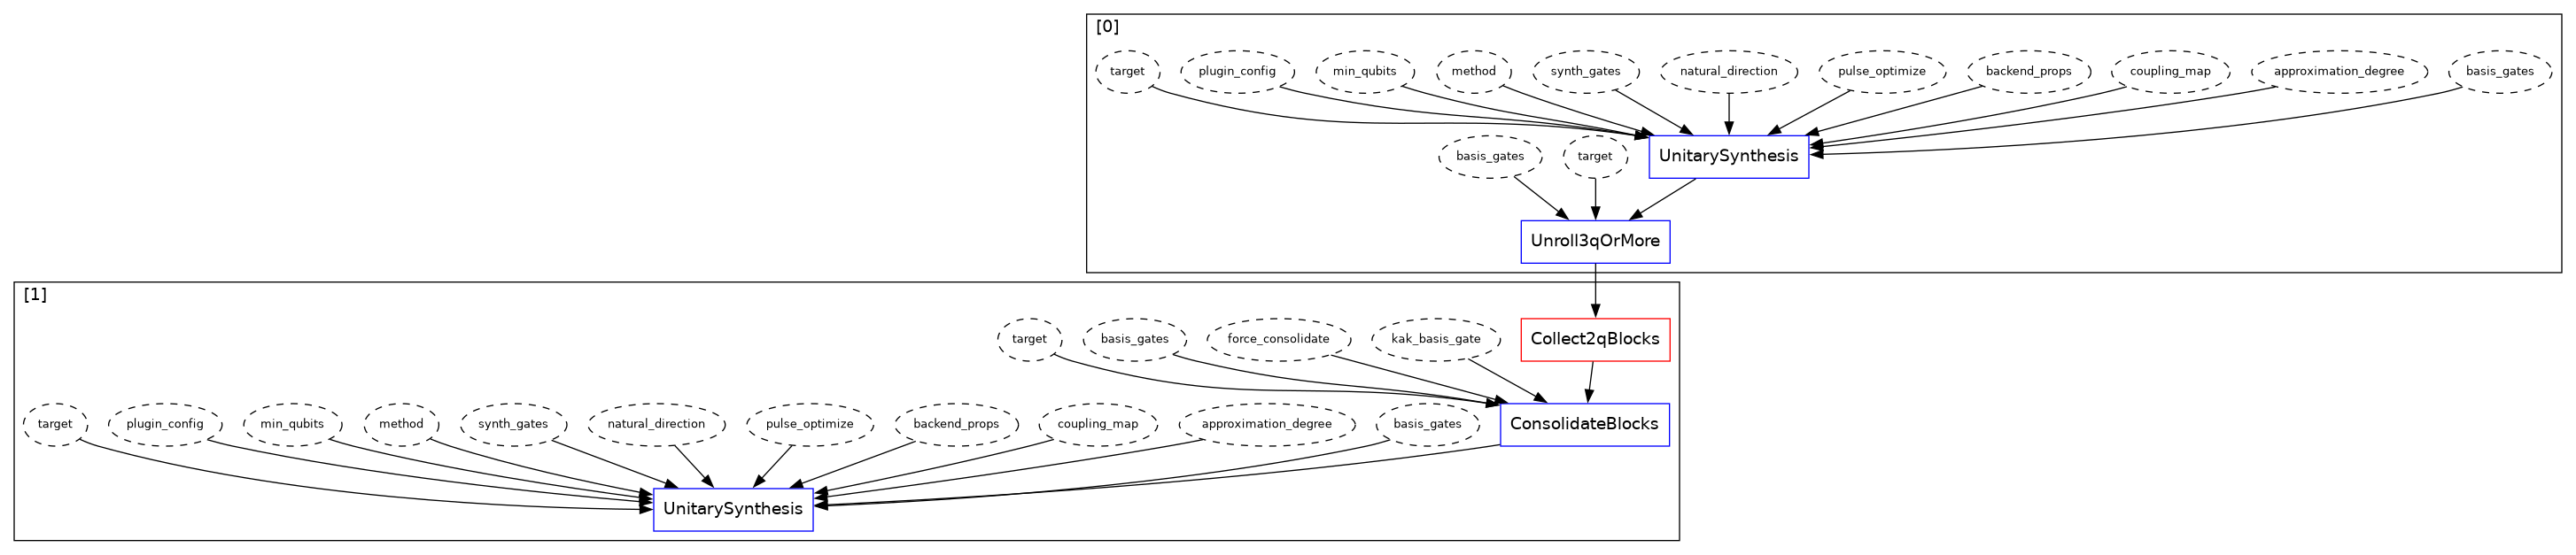

In [4]:
staged_pm.draw()

Stages have an implicitly created `pre_` and `post_` stage that run before and after each defined stage. This provides extra flexability if passes need to be run between stages

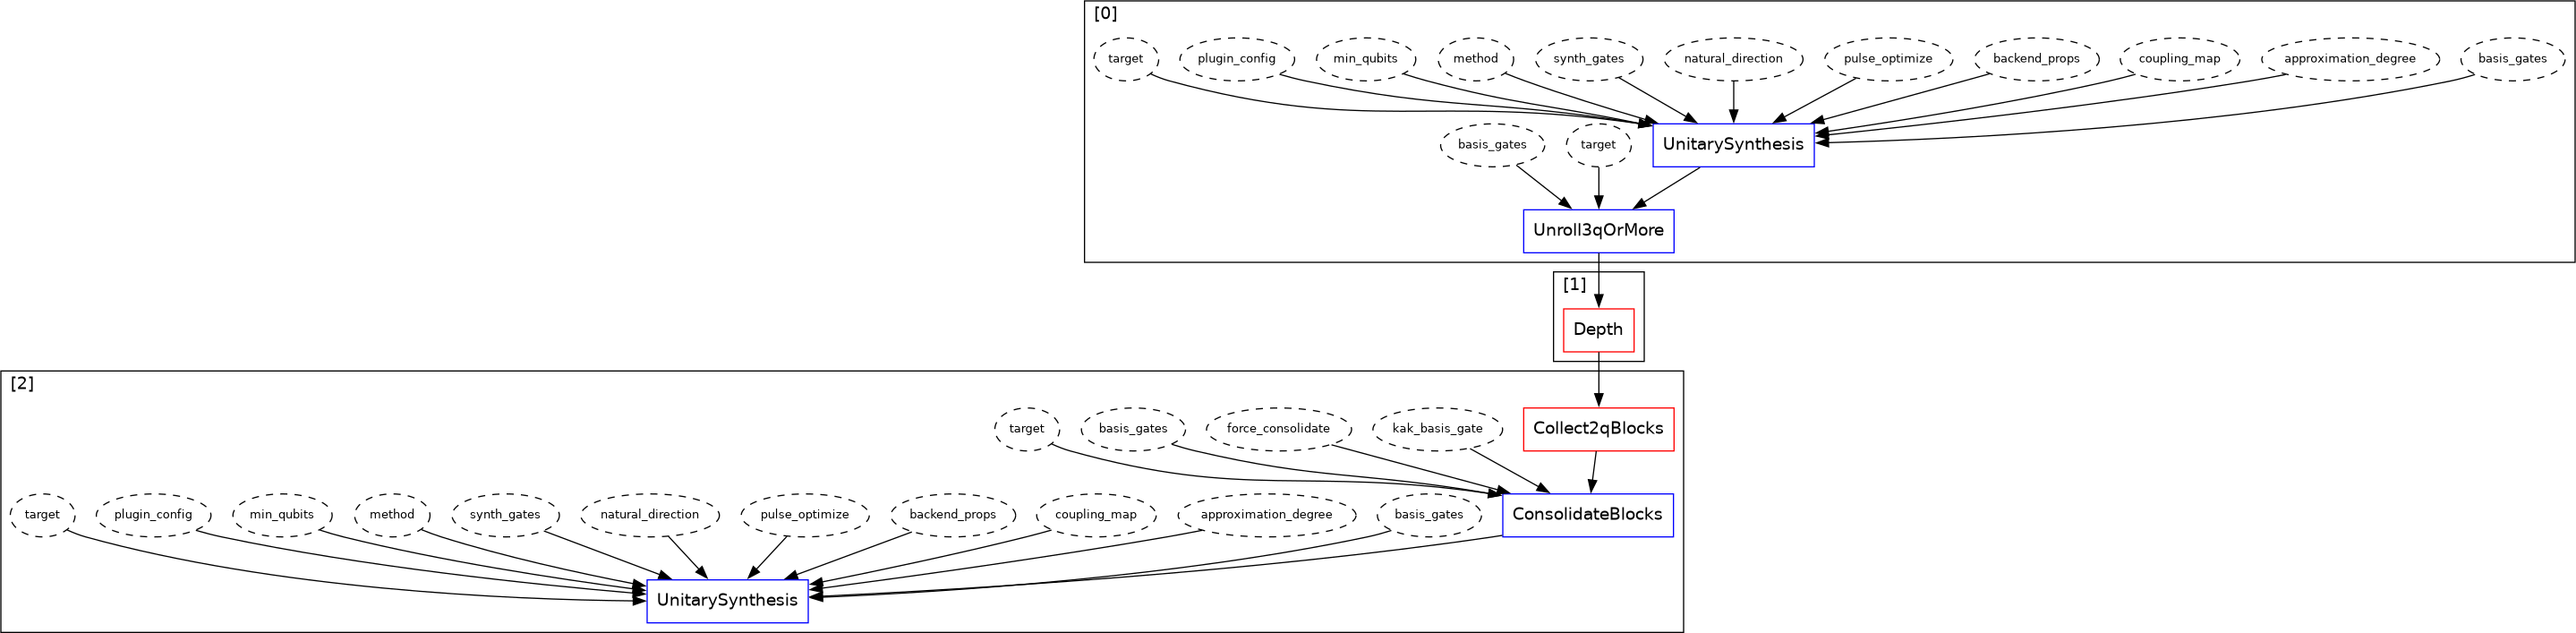

In [5]:
from qiskit.transpiler.preset_passmanagers import common
from qiskit.transpiler import CouplingMap
cmap = CouplingMap.from_grid(2, 2)
staged_pm.pre_layout = common.generate_unroll_3q(None, ['u', 'cx'])
staged_pm.post_layout = common.generate_pre_op_passmanager(coupling_map=cmap)
staged_pm.pre_translation = PassManager(Depth())
staged_pm.draw()

While stages provide composibility and a high level structure/flow to the pass manager, they do restrict how we can interact with them. Instead of being able to modify and add passes to the `StagedPassManager` directly this now has to happen at the individual stage. So for example if you wanted to add a pass to the end of the execution you would have to do this at the end of the last stage.

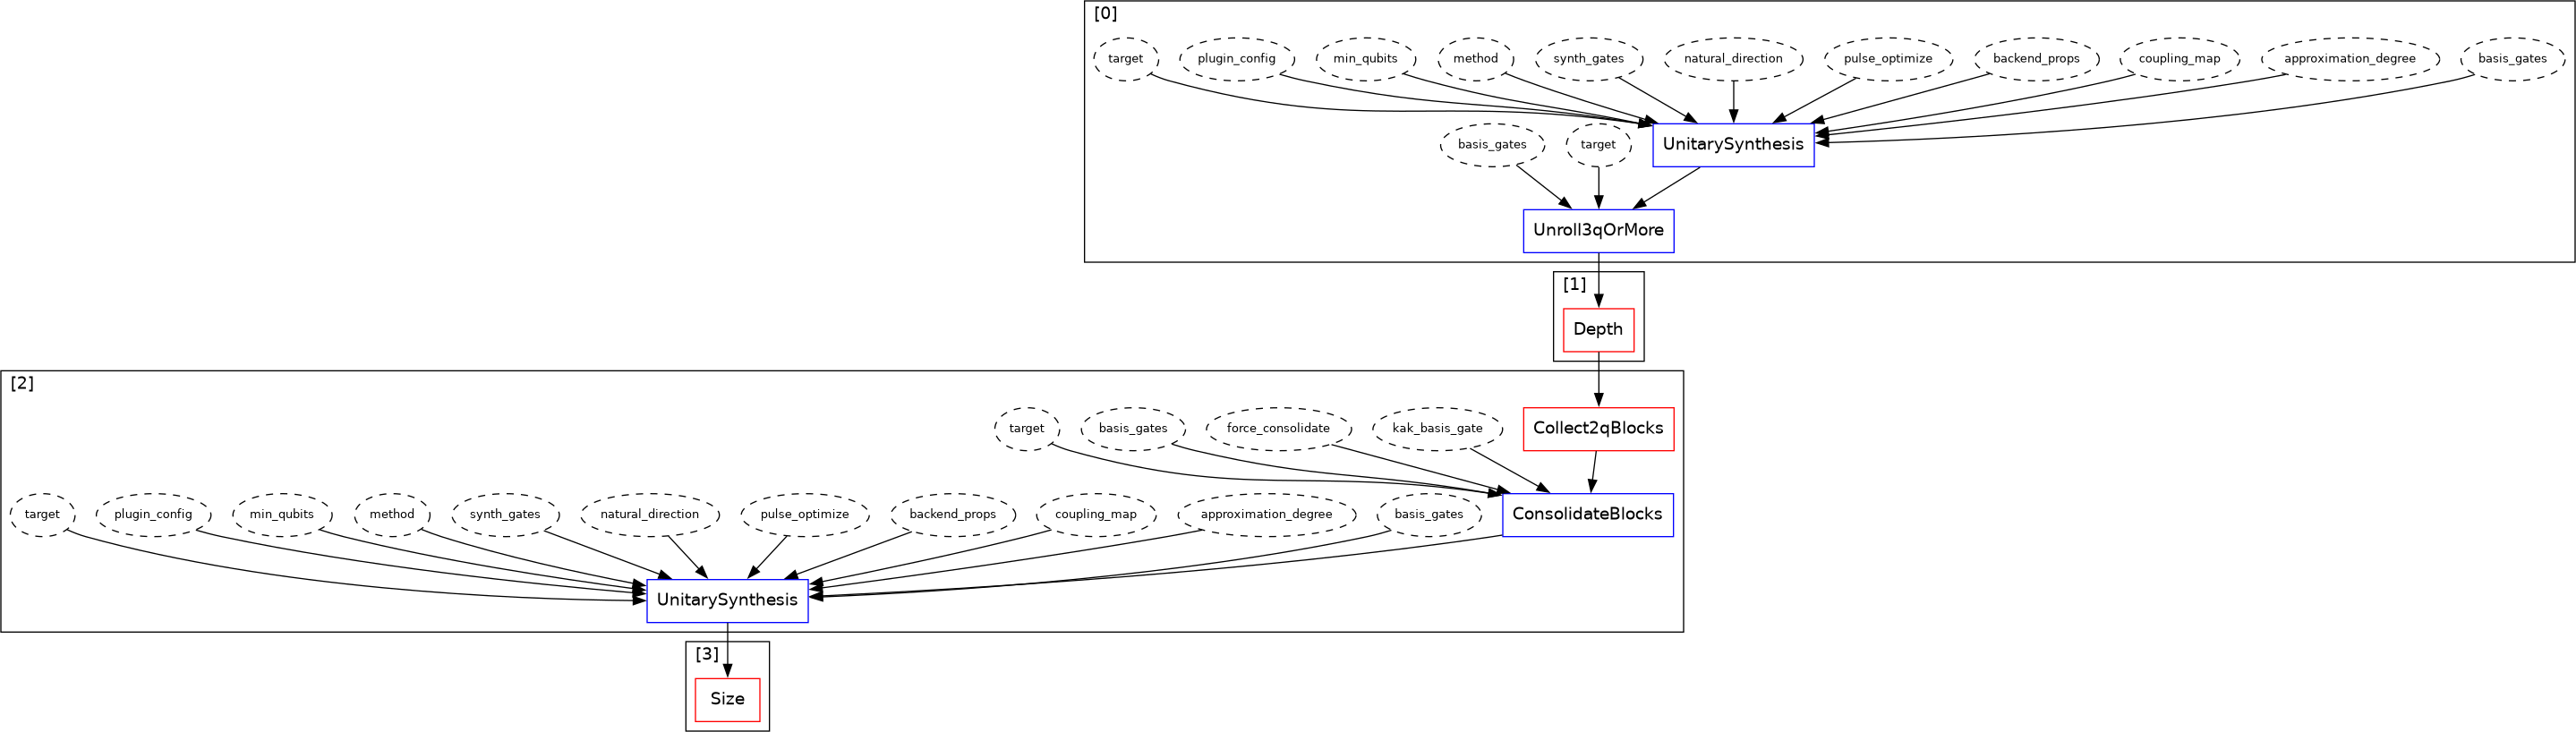

In [6]:
staged_pm.translation.append(Size())
staged_pm.draw()

By default the stages created in a `StagedPassManager` mirror the stages in the preset pass managers used internally by `transpile()`. This makes it easier to build completely custom workflows similar to how `transpile()` works.

In [7]:
staged_pm = StagedPassManager()
print(staged_pm.stages)

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')


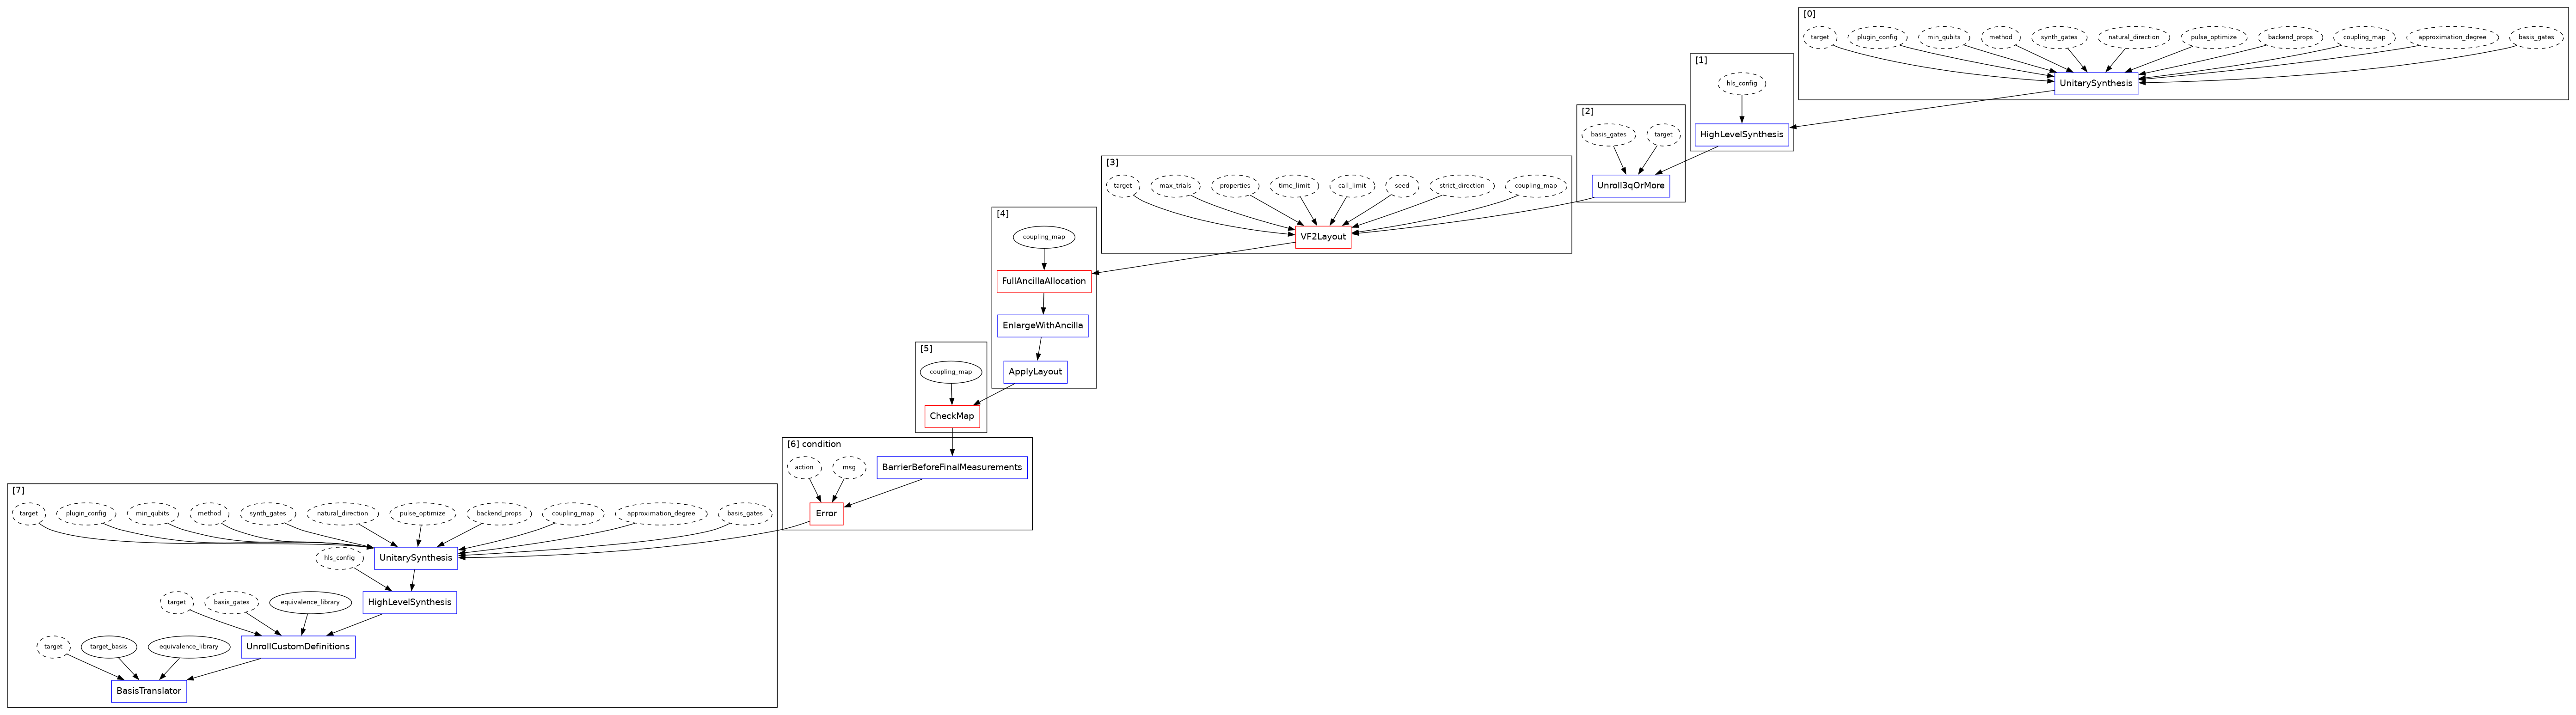

In [8]:
from qiskit.providers.fake_provider import FakeNairobiV2

backend = FakeNairobiV2()
# Pass manager equivalent to transpile(qc, backend, routing_method='none') without optimization
staged_pm.init = common.generate_unroll_3q(backend.target)
staged_pm.layout = PassManager([VF2Layout(target=backend.target, seed=3_29_2023)])
staged_pm.layout += common.generate_embed_passmanager(backend.coupling_map)
staged_pm.routing = common.generate_routing_passmanager(Error(), backend.target)
staged_pm.translation = common.generate_translation_passmanager(backend.target)
staged_pm.draw()

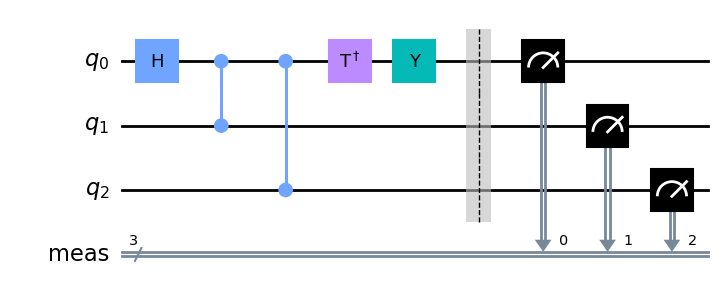

In [9]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(3)
qc.h(0)
qc.cz(0, 1)
qc.cz(0, 2)
qc.tdg(0)
qc.y(0)
qc.measure_all()
qc.draw('mpl')

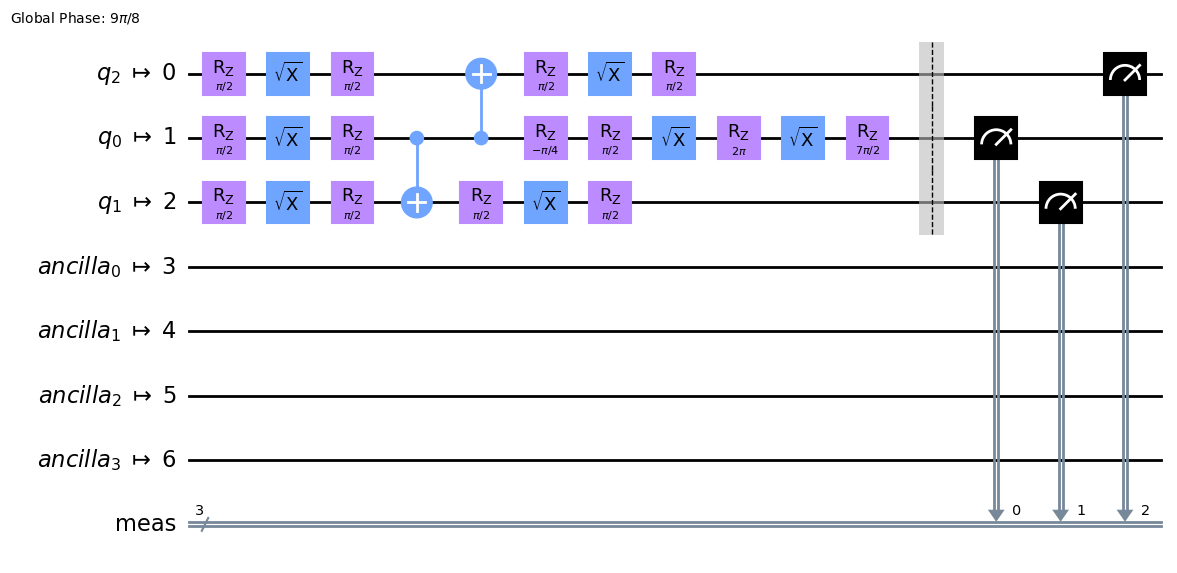

In [10]:
staged_pm.run(qc).draw('mpl')

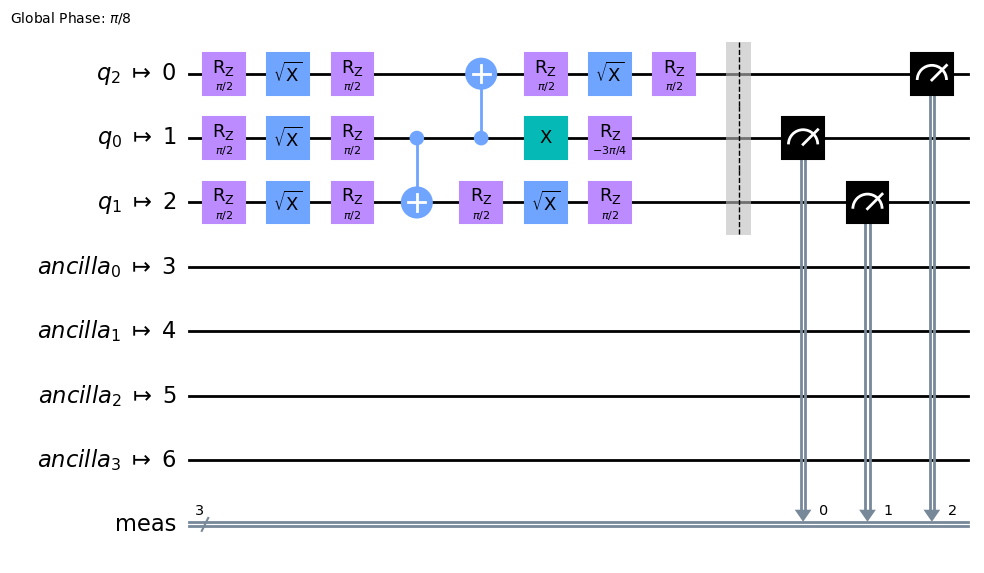

In [11]:
from qiskit import transpile
transpile(qc, backend, seed_transpiler=3_29_2023).draw('mpl')

In [12]:
from qiskit.transpiler.exceptions import TranspilerError

qc = QuantumCircuit(5)
qc.h(0)
qc.cz(0, 1)
qc.cz(0, 2)
qc.cz(0, 3)
qc.cz(0, 4)
qc.tdg(0)
qc.y(0)
qc.measure_all()
qc.draw('mpl')

try:
    staged_pm.run(qc)
except TranspilerError:
    print("Fails as VF2Layout doesn't find a perfect layout")

Fails as VF2Layout doesn't find a perfect layout


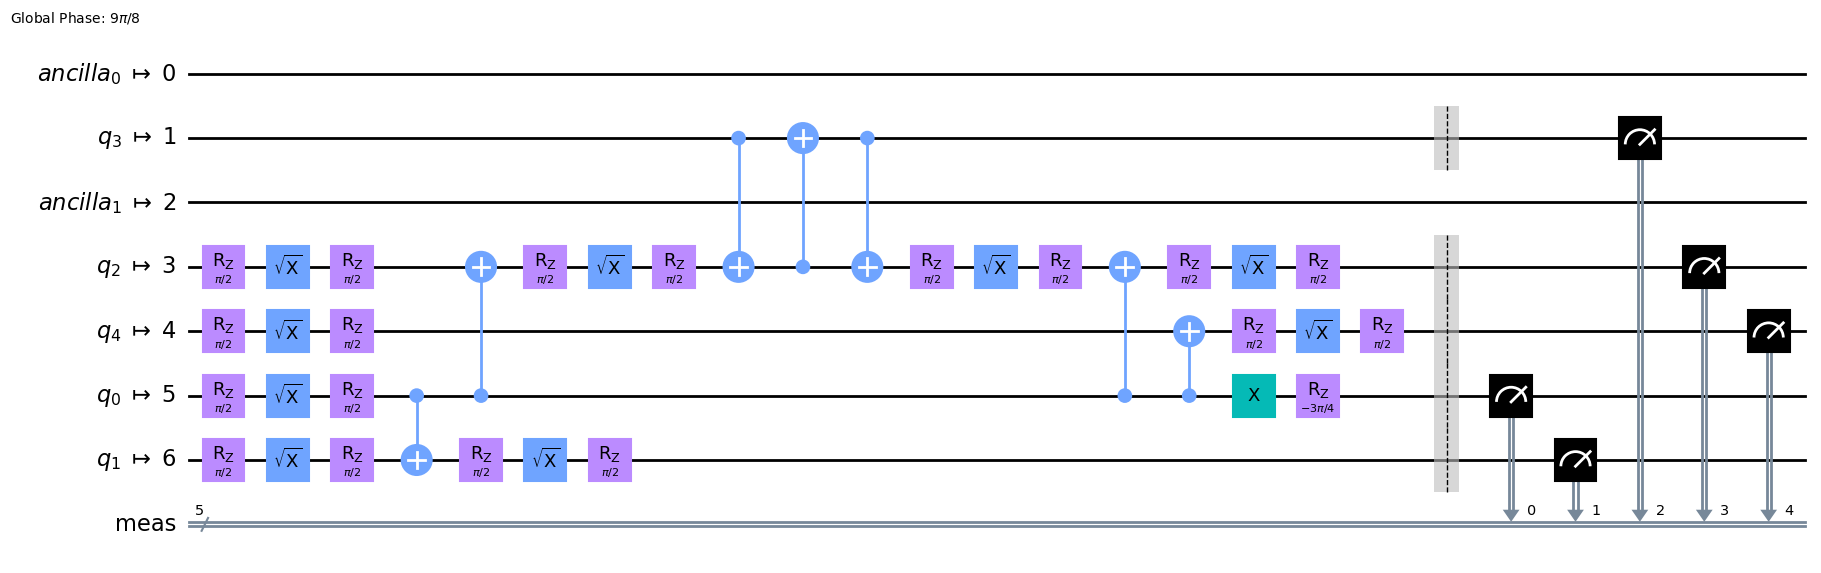

In [13]:
transpile(qc, backend, seed_transpiler=3_29_2023).draw('mpl')

### Working with Preset Pass Managers

While being able to label your own stages provides nice flexibility and composability options to interacting with `PassManager`s the real power of this interface comes with working with the preset pass managers, or those that get used internally by the `transpile()` function.

It's now much easier to create preset pass managers, there is a new generator function `generate_preset_pass_managers()` which has the same signature as `transpile()`. To ease in working with and modifying the preset pass manager the preset pass managers are now all `StagedPassManager`s.

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeBelemV2
backend = FakeBelemV2()
pm = generate_preset_pass_manager(1, backend, seed_transpiler=3_29_2023)
print(type(pm))

<class 'qiskit.transpiler.passmanager.StagedPassManager'>


In [15]:
print(pm.stages)

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')


These stages are the same as the default stages if you instantiate a `StagedPassManager` without any stages defined explicitly

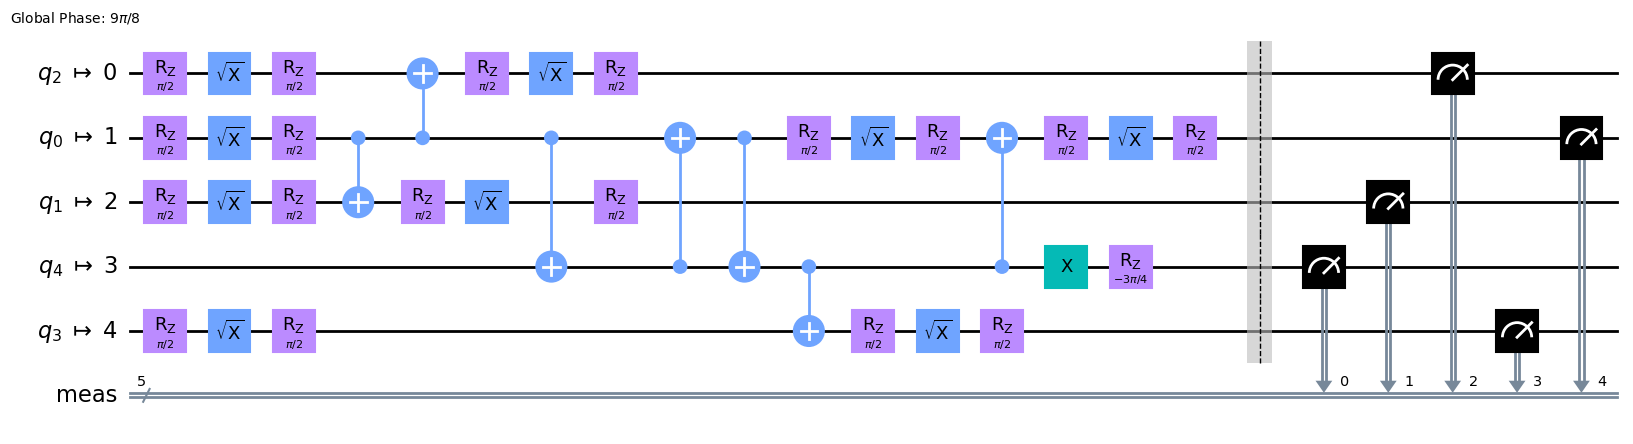

In [16]:
pm.run(qc).draw('mpl')

Having these stages defined make it trivial to replace or modify a section of the preset pass managers to use a normal/default workflow with some tweaks. For example, lets add some logical optimization (CNOT and inverse cancellation) prior to running layout and then also run dynamical decoupling for scheduling:

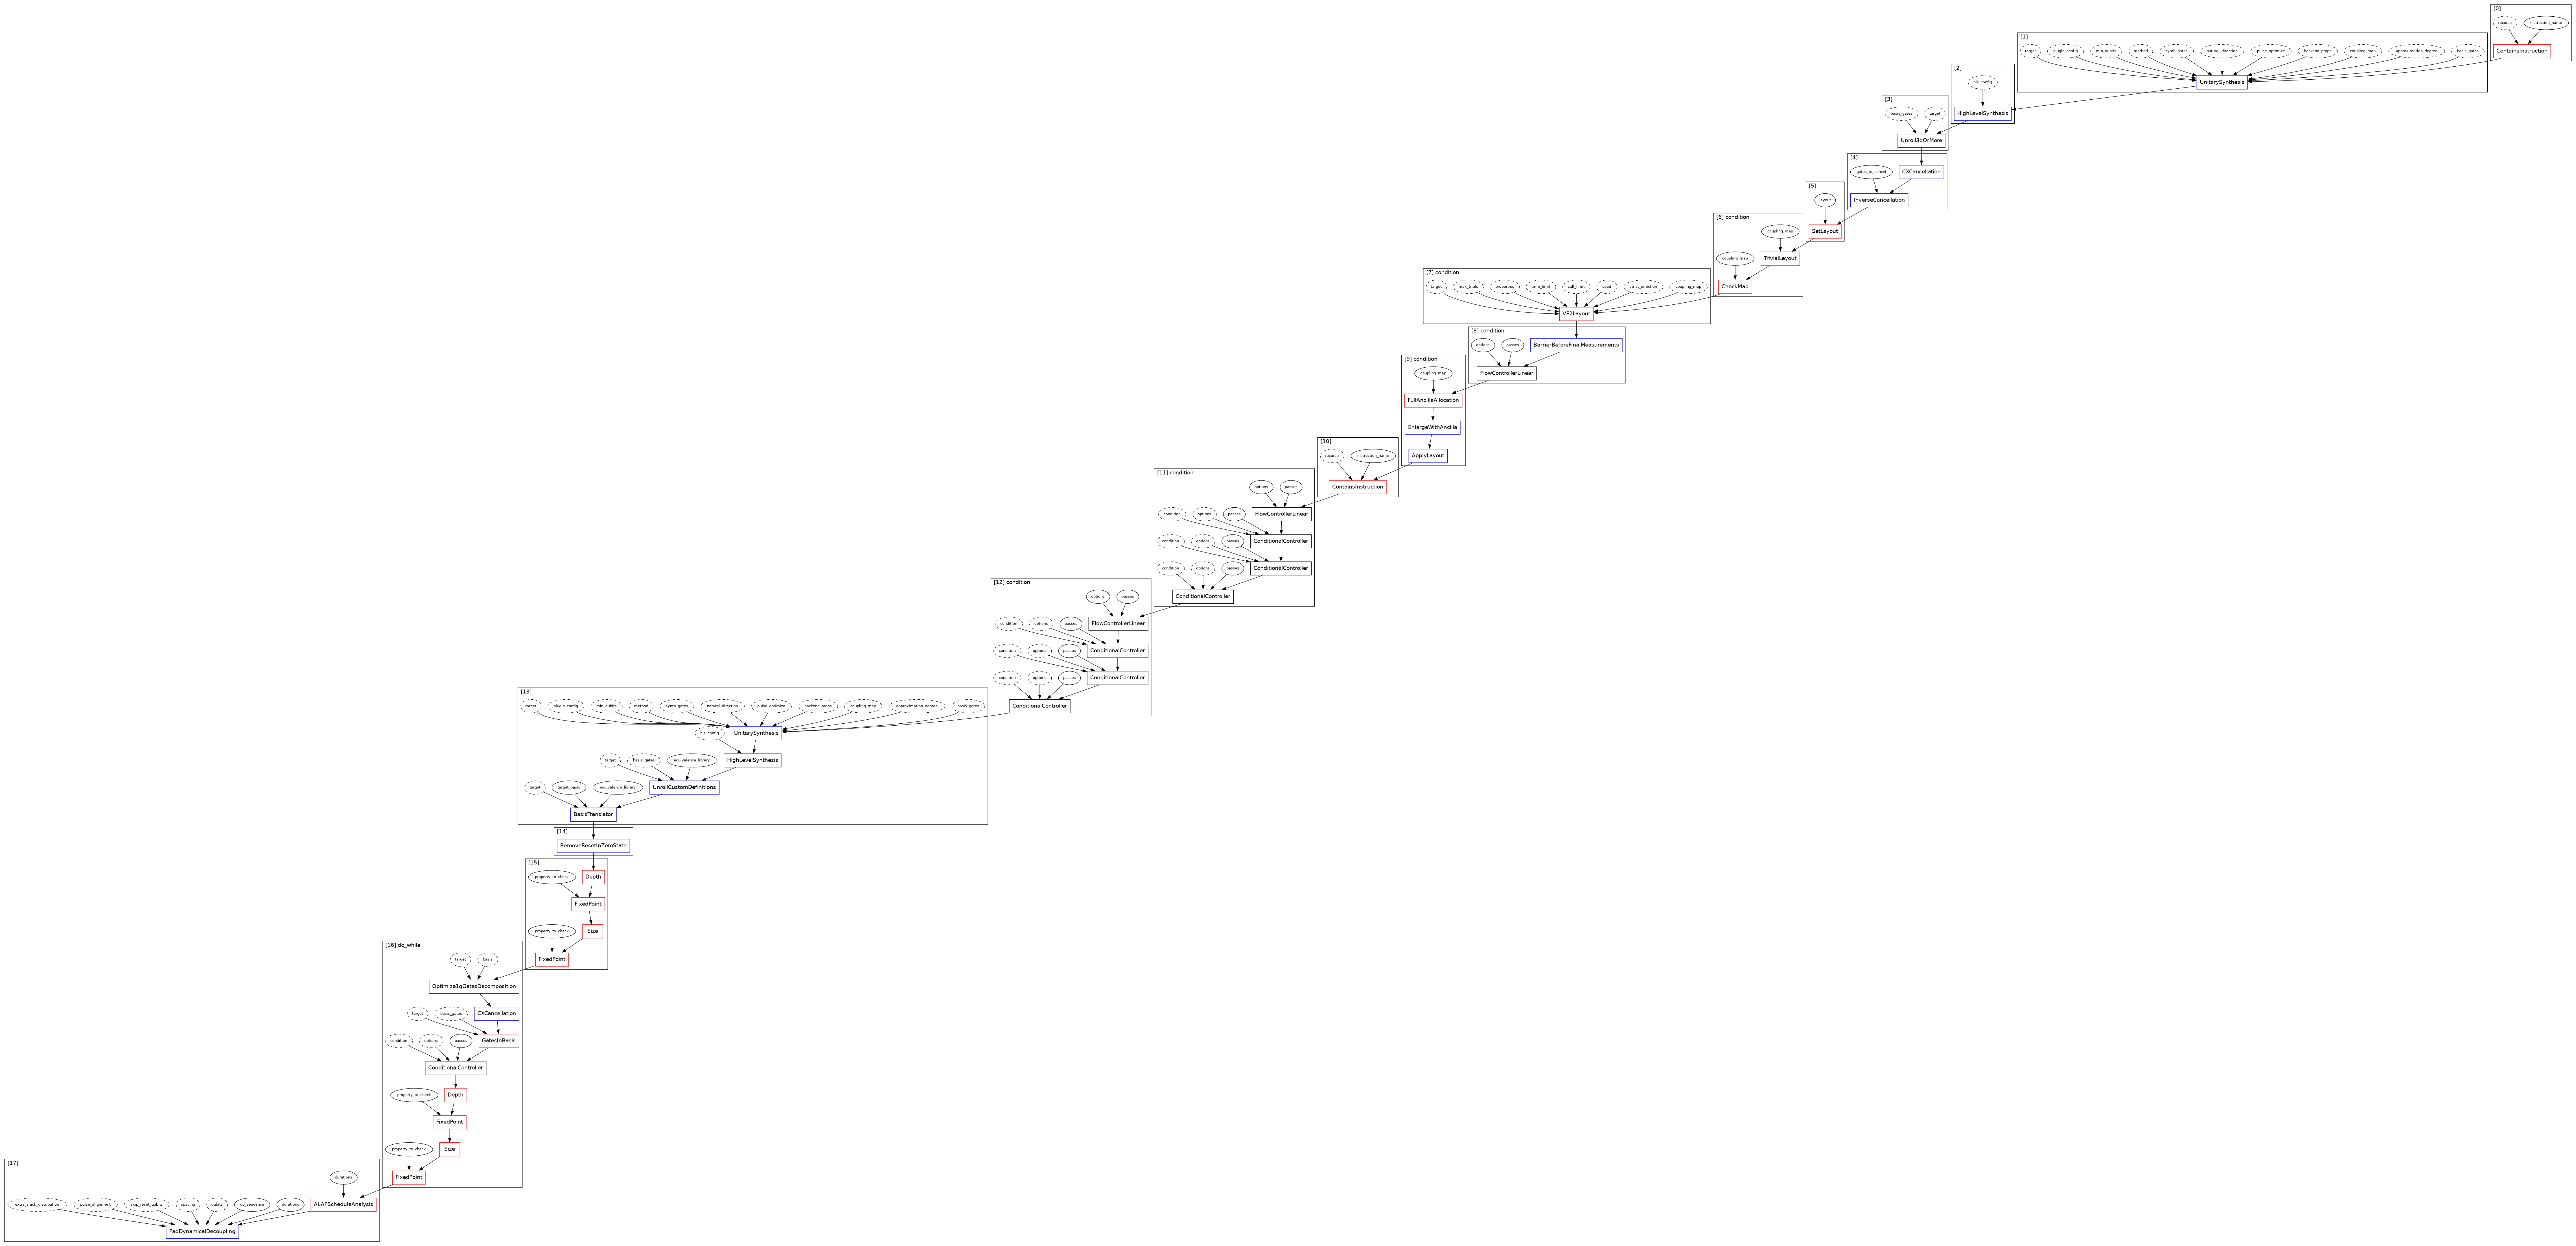

In [17]:
from qiskit.circuit.library import XGate, HGate, RXGate, PhaseGate, TGate, TdgGate
import numpy as np

backend_durations = backend.target.durations()

dd_sequence = [XGate(), XGate()]

scheduling_pm = PassManager([
    ALAPScheduleAnalysis(backend_durations),
    PadDynamicalDecoupling(backend_durations, dd_sequence),
])

inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]

logical_opt = PassManager([
    CXCancellation(),
    InverseCancellation([HGate(), (RXGate(np.pi / 4), RXGate(-np.pi / 4))])
])

# Run DD for scheduling stage
pm.scheduling = scheduling_pm
# Run  logical optimization prior to layout stage
pm.pre_layout = logical_opt
pm.draw()

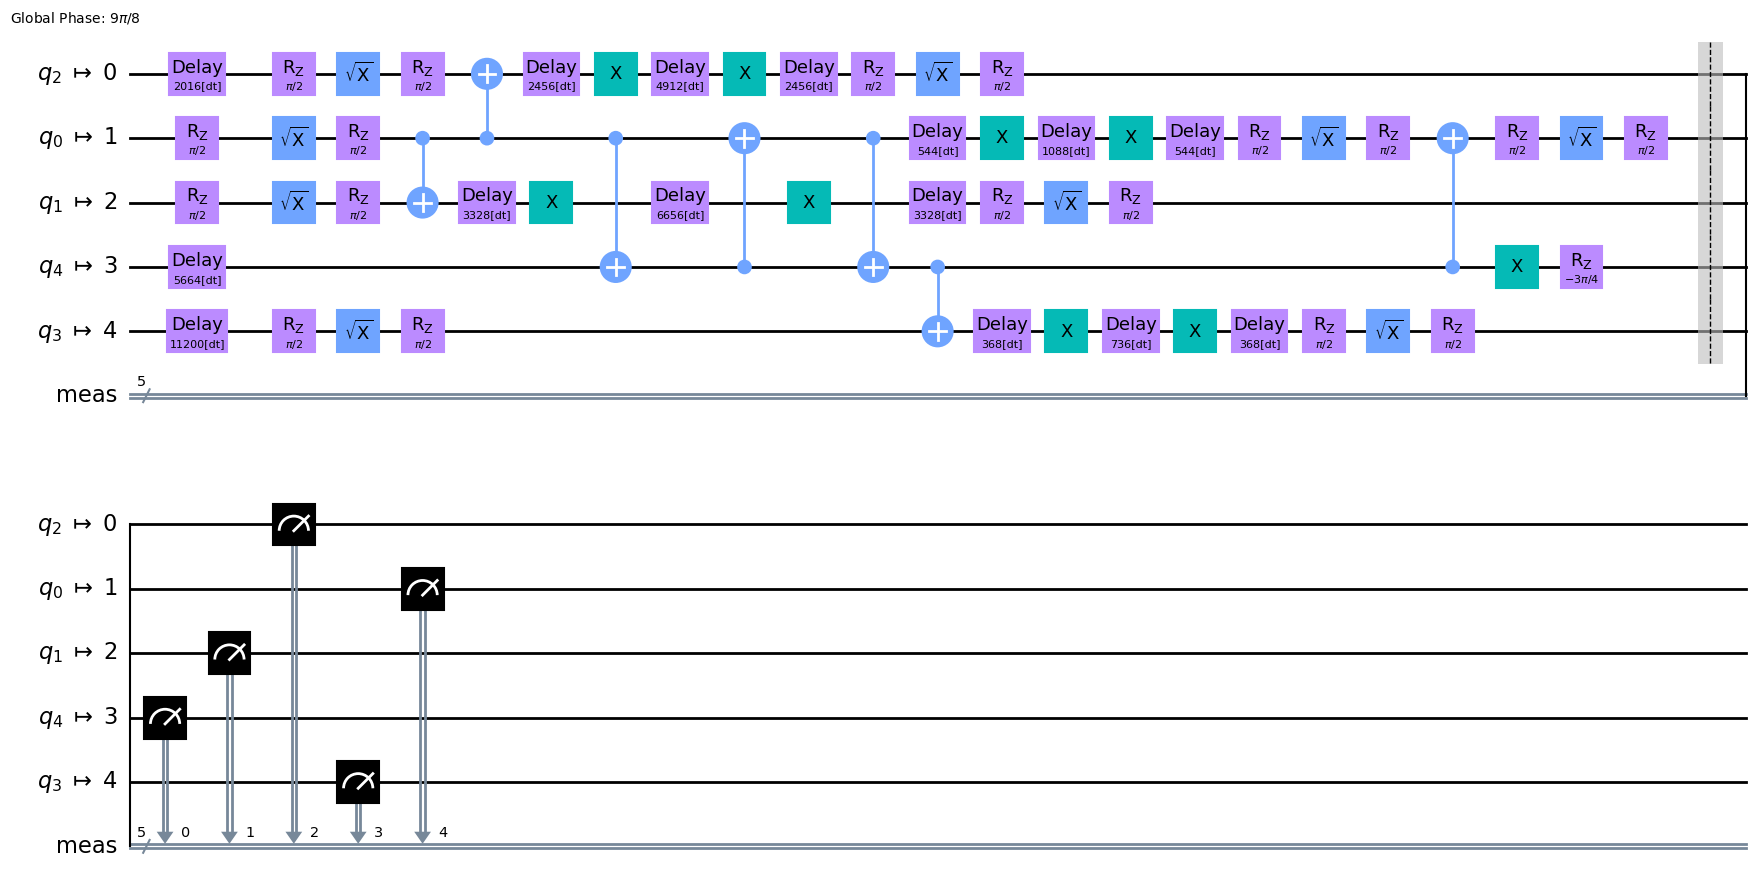

In [18]:
pm.run(qc).draw('mpl')

We can also replace stages completely which might be necessary if you're running passes not included out of the box, For example, `BIPMapping` is a routing pass that depends on the proprietary CPLEX solver (and is not included by default in any pipeline). But we can integrate it easily by replacing the `routing` stage with it.

In [19]:
pm.routing = PassManager([BIPMapping(backend.coupling_map)])

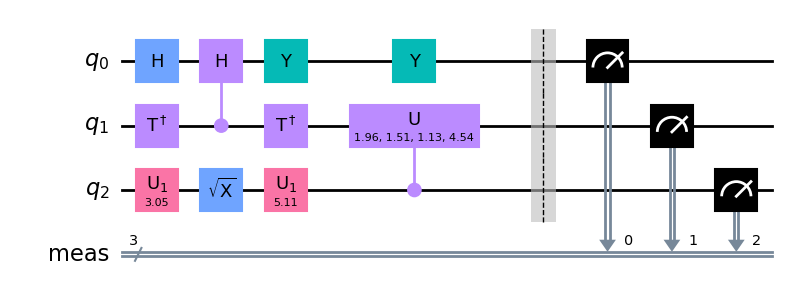

In [20]:
from qiskit.circuit.random import random_circuit
qc = random_circuit(3, 4, seed=3_29_2023)
qc.measure_all()
qc.draw('mpl')

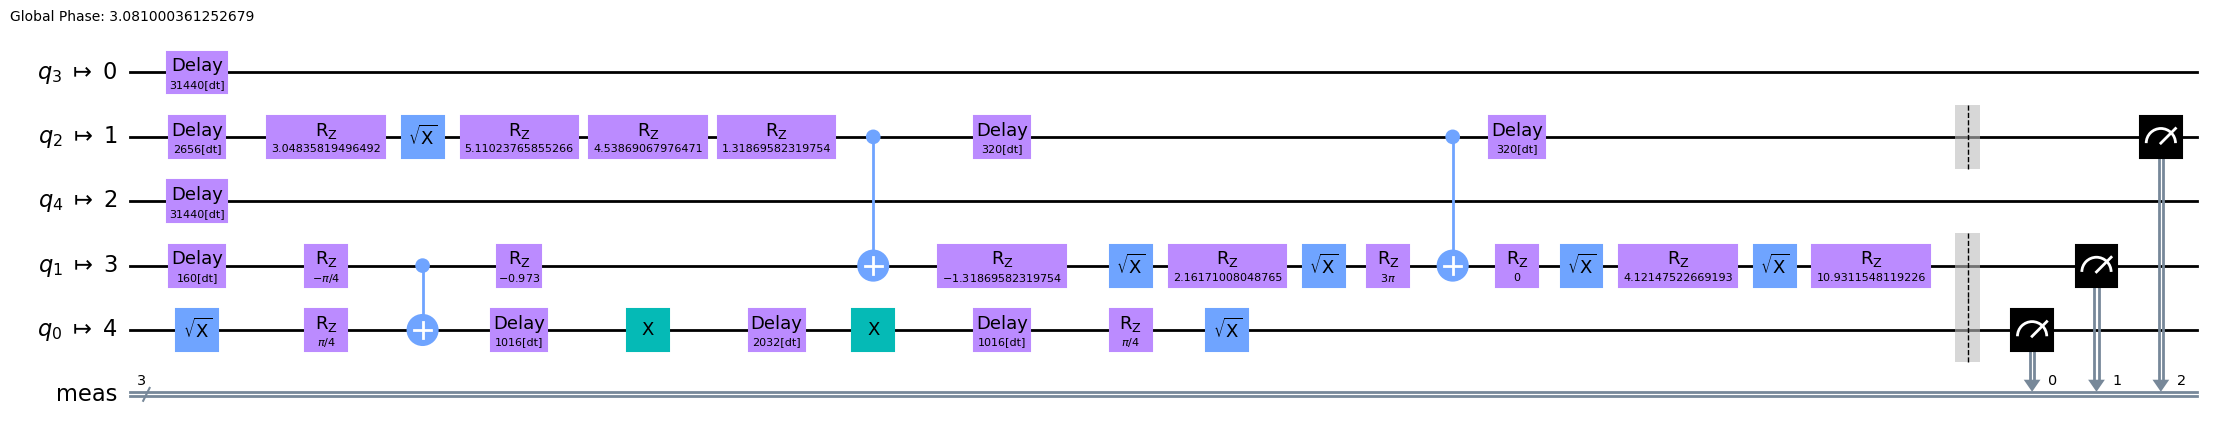

In [21]:
pm.run(qc).draw('mpl', fold=-1)

We can see this in progress too, by printing the stage and output of each pass run using a callback:

Circuit state after running <qiskit.transpiler.passes.utils.contains_instruction.ContainsInstruction object at 0x7f8be4917010>:


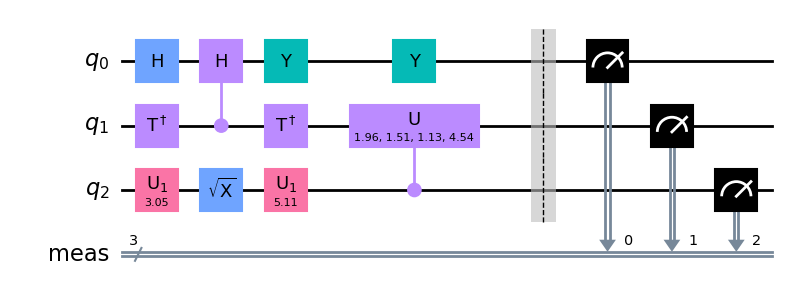

Circuit state after running <qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis object at 0x7f8be4914df0>:


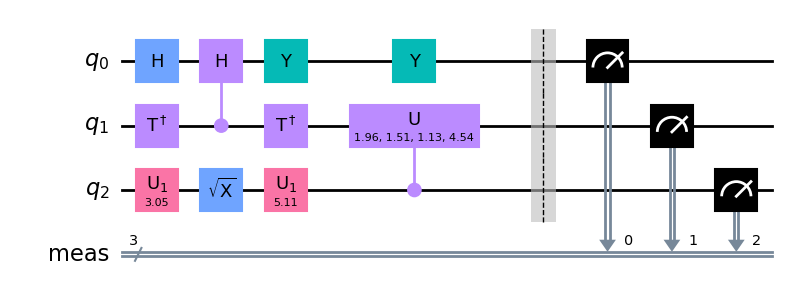

Circuit state after running <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x7f8be4915c30>:


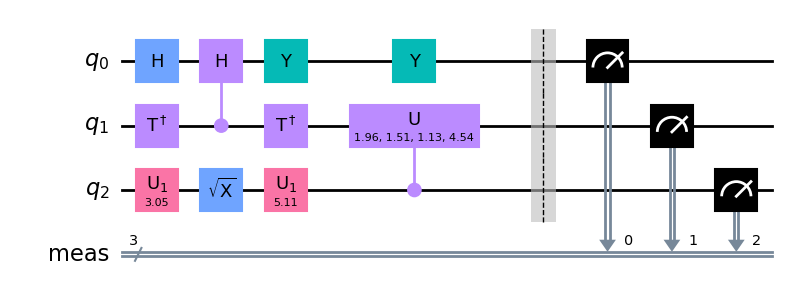

Circuit state after running <qiskit.transpiler.passes.basis.unroll_3q_or_more.Unroll3qOrMore object at 0x7f8be4917a00>:


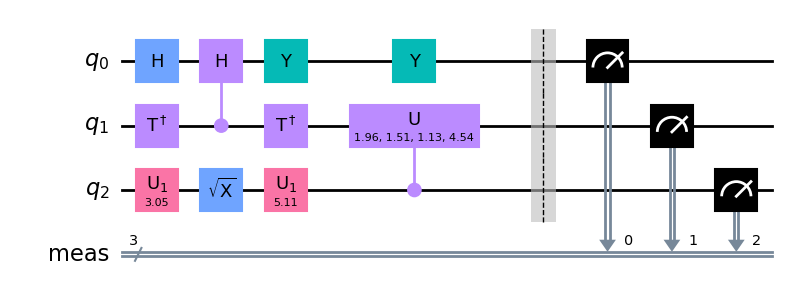

Circuit state after running <qiskit.transpiler.passes.optimization.cx_cancellation.CXCancellation object at 0x7f8be47c94b0>:


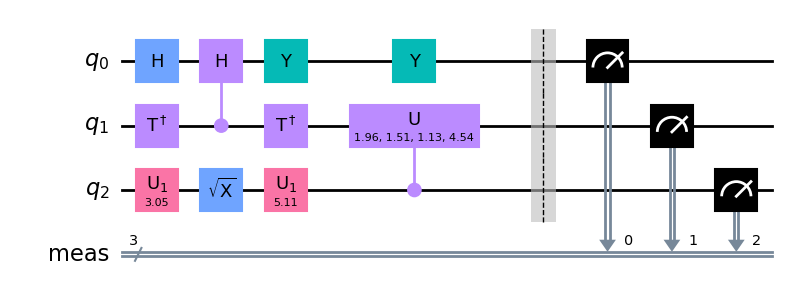

Circuit state after running <qiskit.transpiler.passes.optimization.inverse_cancellation.InverseCancellation object at 0x7f8be47cac20>:


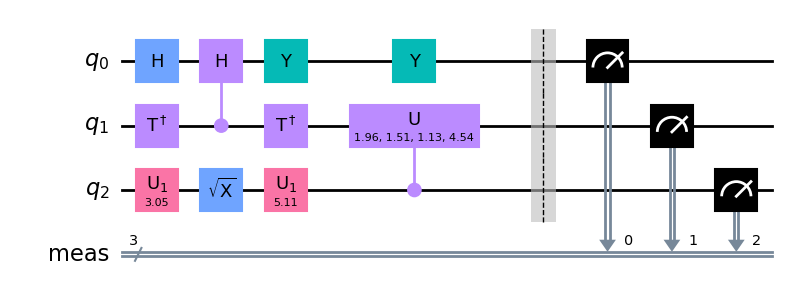

Circuit state after running <qiskit.transpiler.passes.layout.set_layout.SetLayout object at 0x7f8be495e080>:


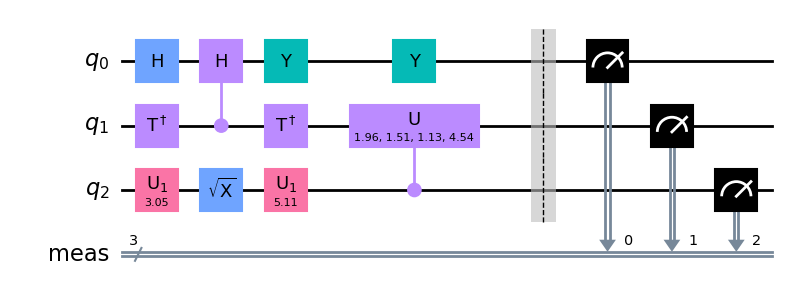

Circuit state after running <qiskit.transpiler.passes.layout.trivial_layout.TrivialLayout object at 0x7f8be495e890>:


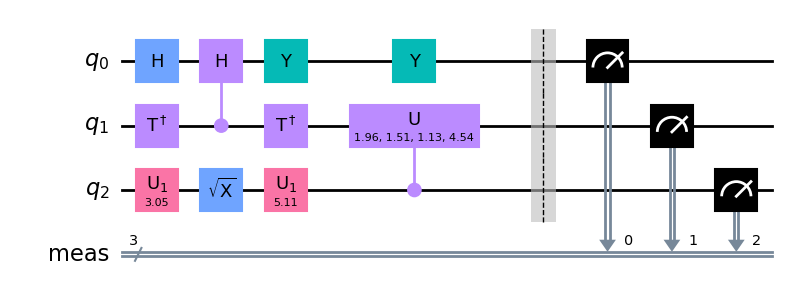

Circuit state after running <qiskit.transpiler.passes.utils.check_map.CheckMap object at 0x7f8be495f970>:


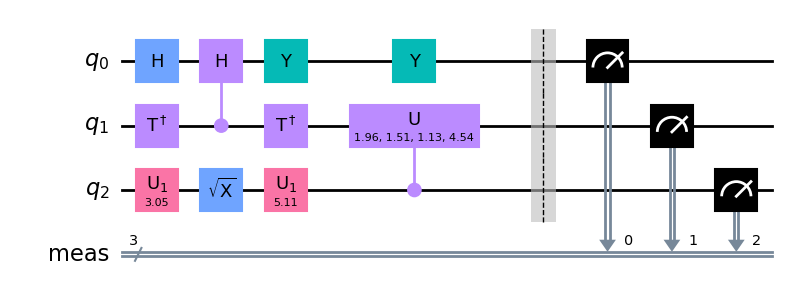

Circuit state after running <qiskit.transpiler.passes.layout.full_ancilla_allocation.FullAncillaAllocation object at 0x7f8be4915000>:


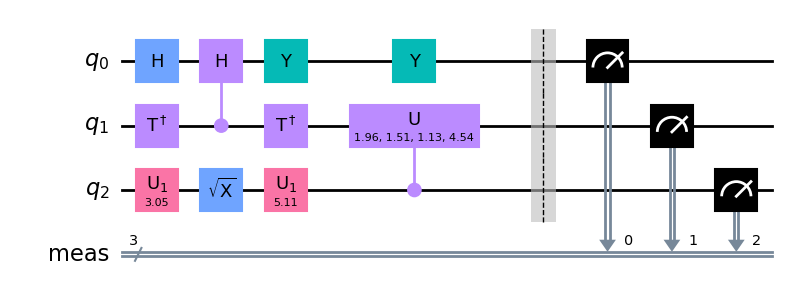

Circuit state after running <qiskit.transpiler.passes.layout.enlarge_with_ancilla.EnlargeWithAncilla object at 0x7f8be4915180>:


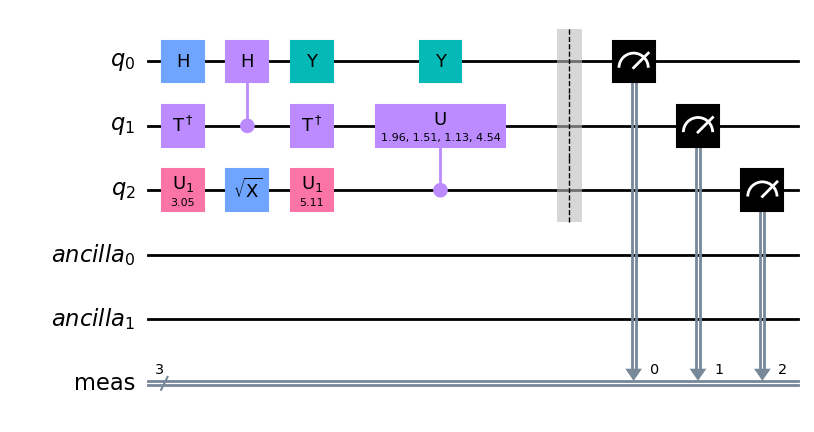

Circuit state after running <qiskit.transpiler.passes.layout.apply_layout.ApplyLayout object at 0x7f8be4914a00>:


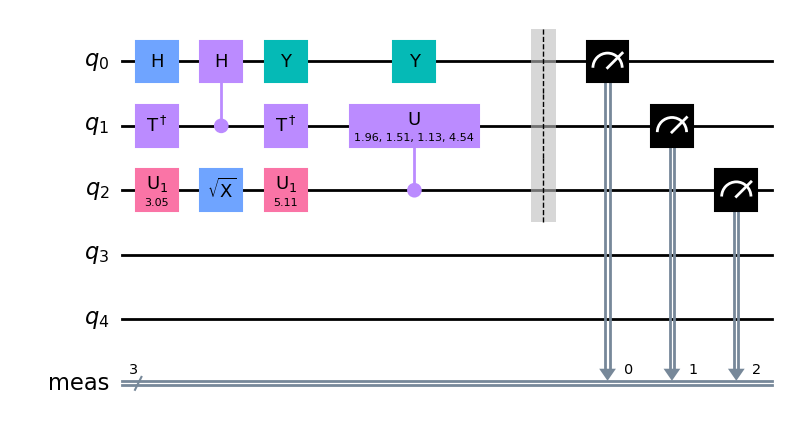

Circuit state after running <qiskit.transpiler.passes.routing.bip_mapping.BIPMapping object at 0x7f8be44422c0>:


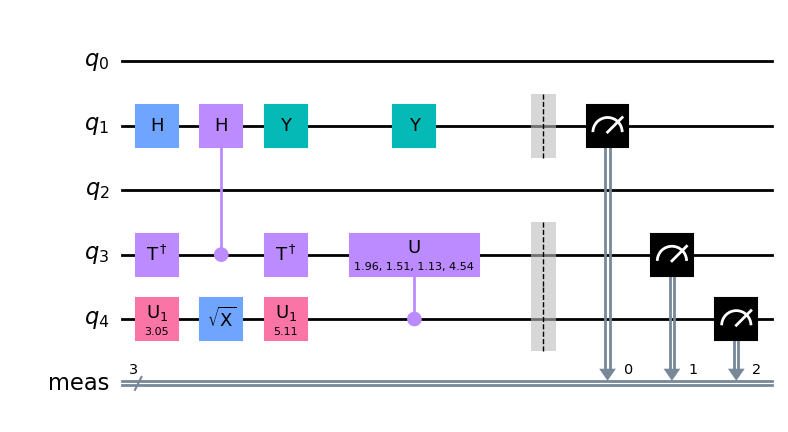

Circuit state after running <qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis object at 0x7f8be4915150>:


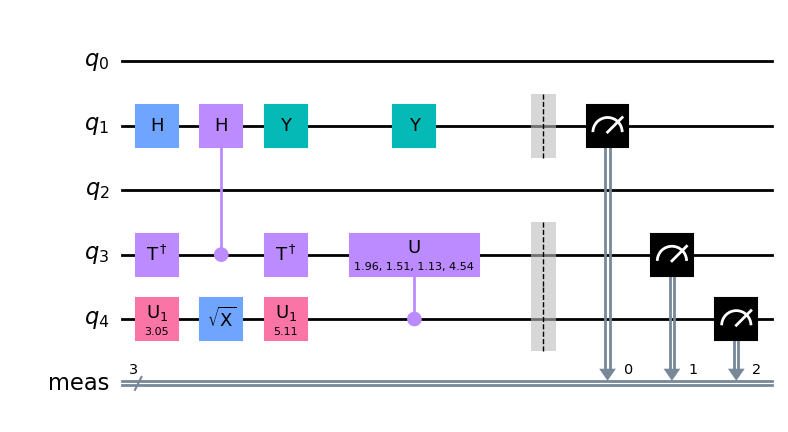

Circuit state after running <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x7f8be4914250>:


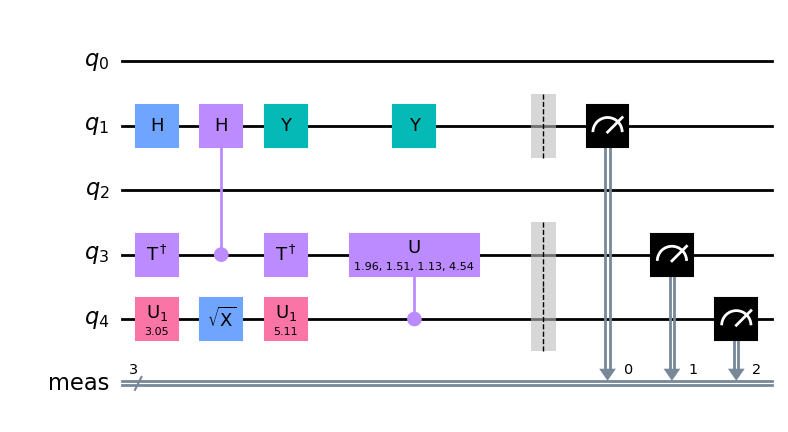

Circuit state after running <qiskit.transpiler.passes.basis.unroll_custom_definitions.UnrollCustomDefinitions object at 0x7f8be4917e50>:


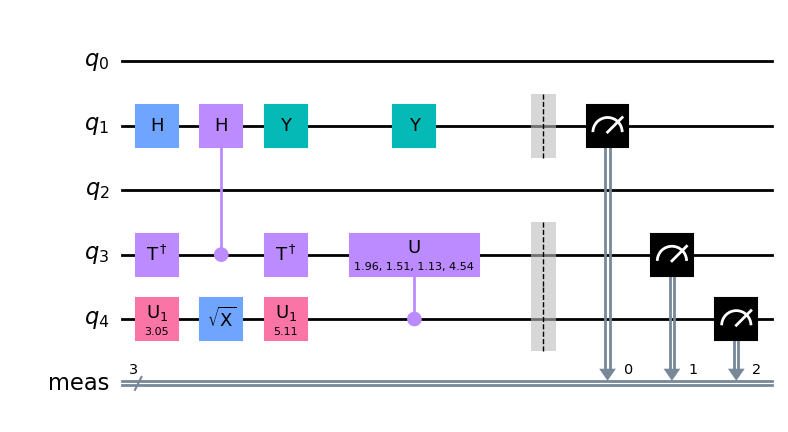

Circuit state after running <qiskit.transpiler.passes.basis.basis_translator.BasisTranslator object at 0x7f8be4914040>:


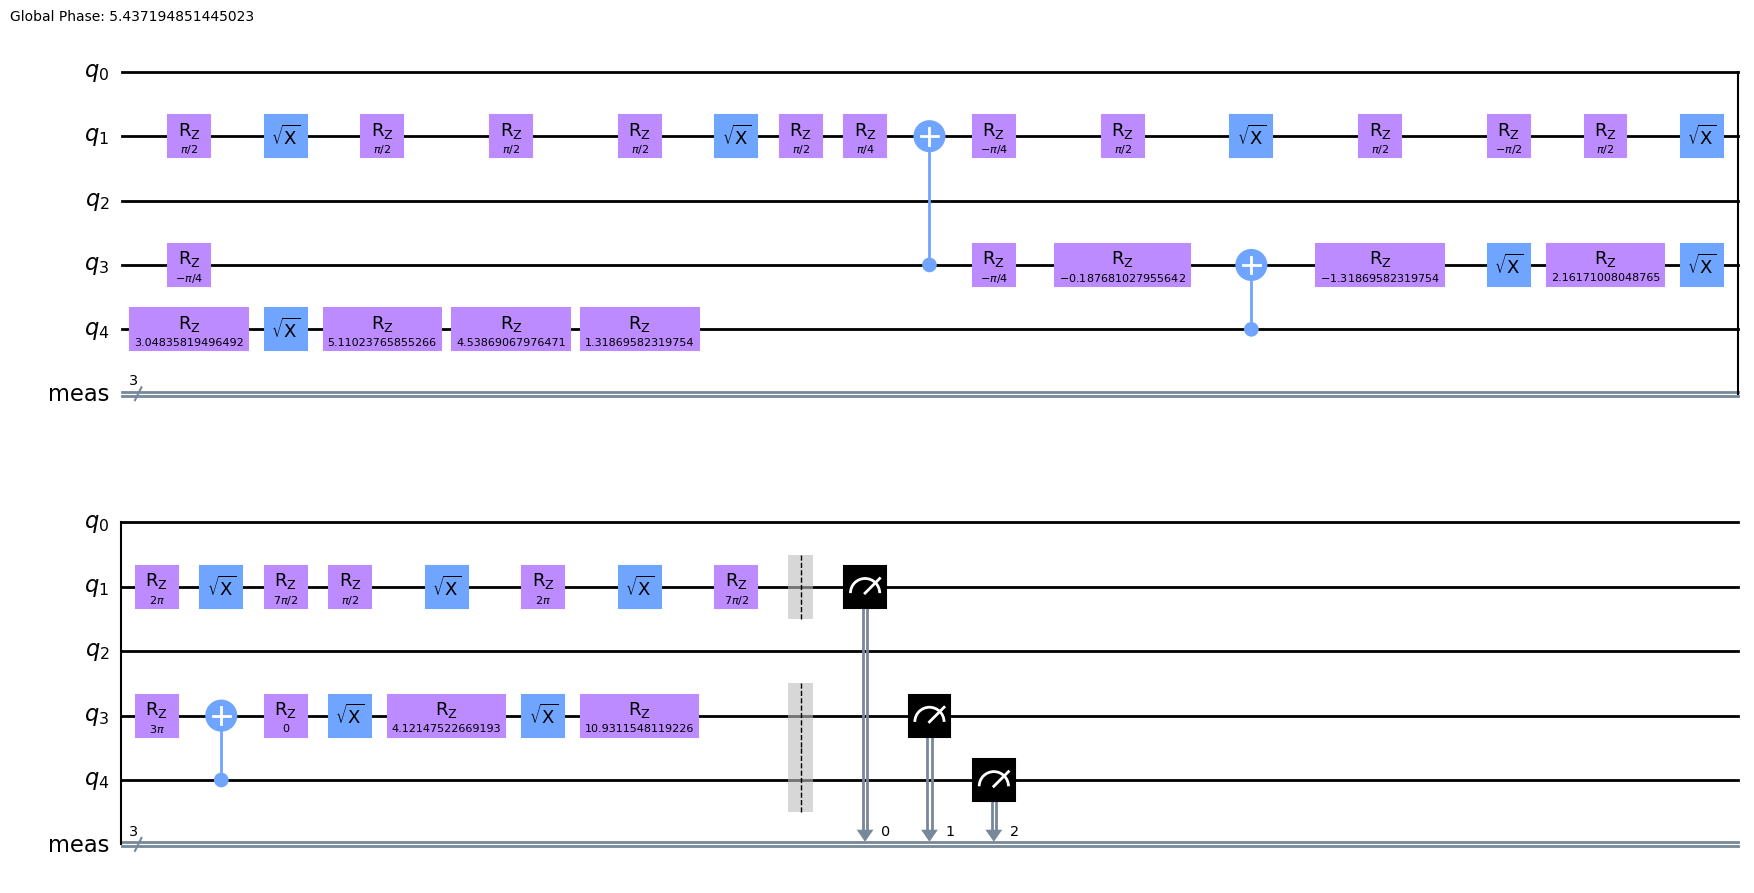

Circuit state after running <qiskit.transpiler.passes.optimization.remove_reset_in_zero_state.RemoveResetInZeroState object at 0x7f8be4914970>:


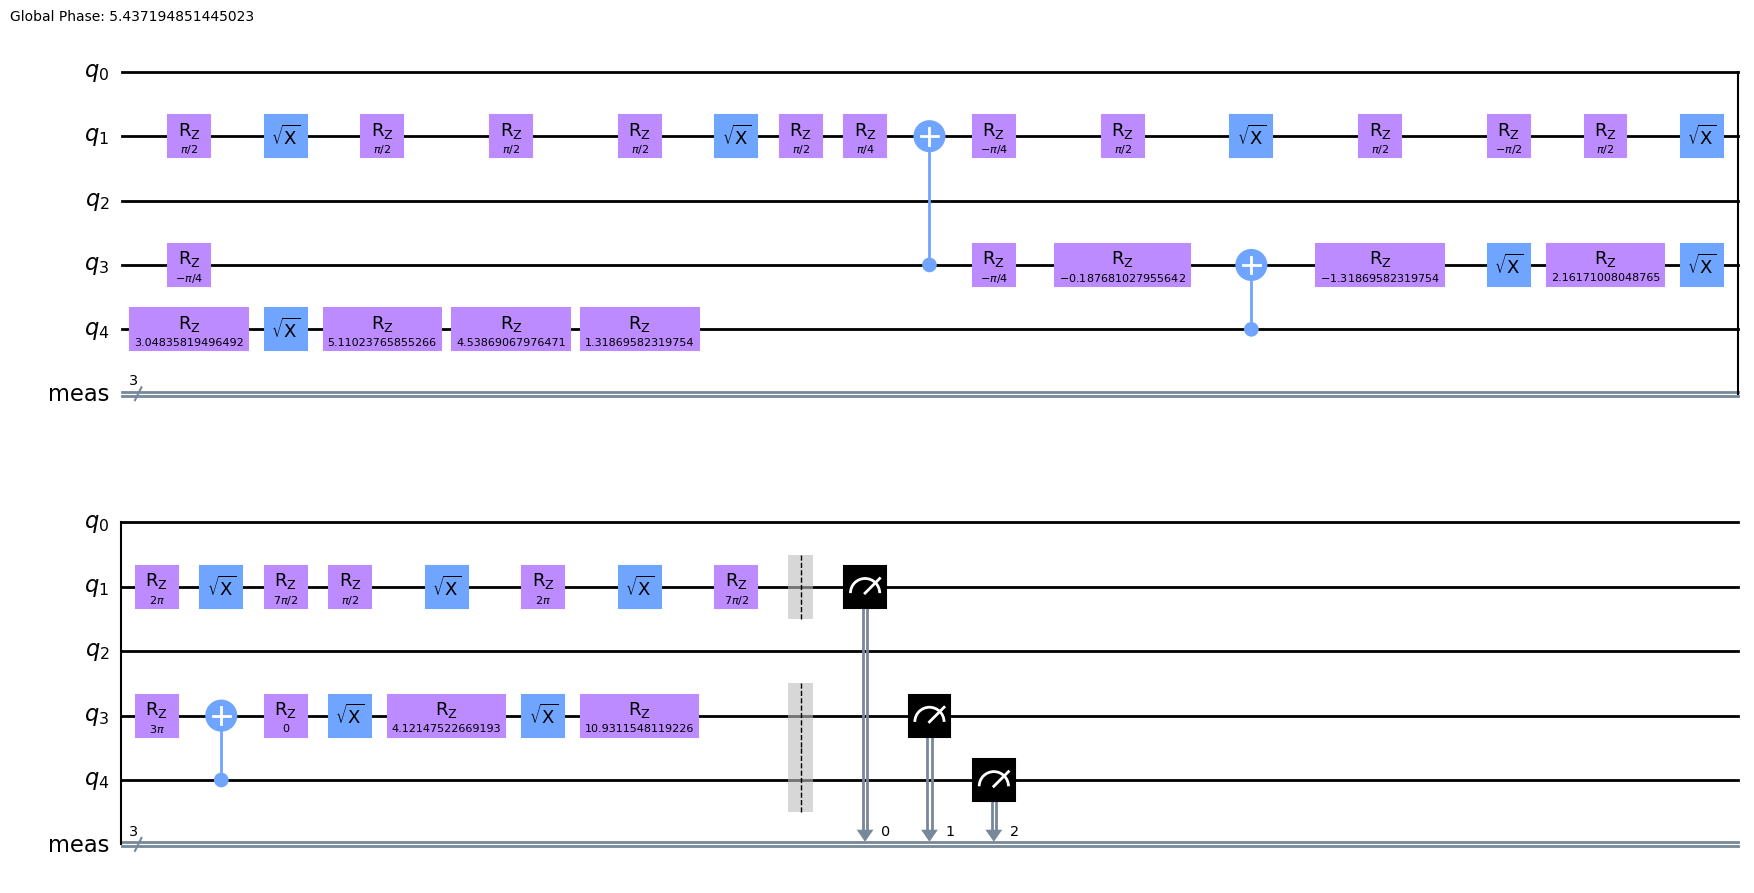

Circuit state after running <qiskit.transpiler.passes.analysis.depth.Depth object at 0x7f8be4917280>:


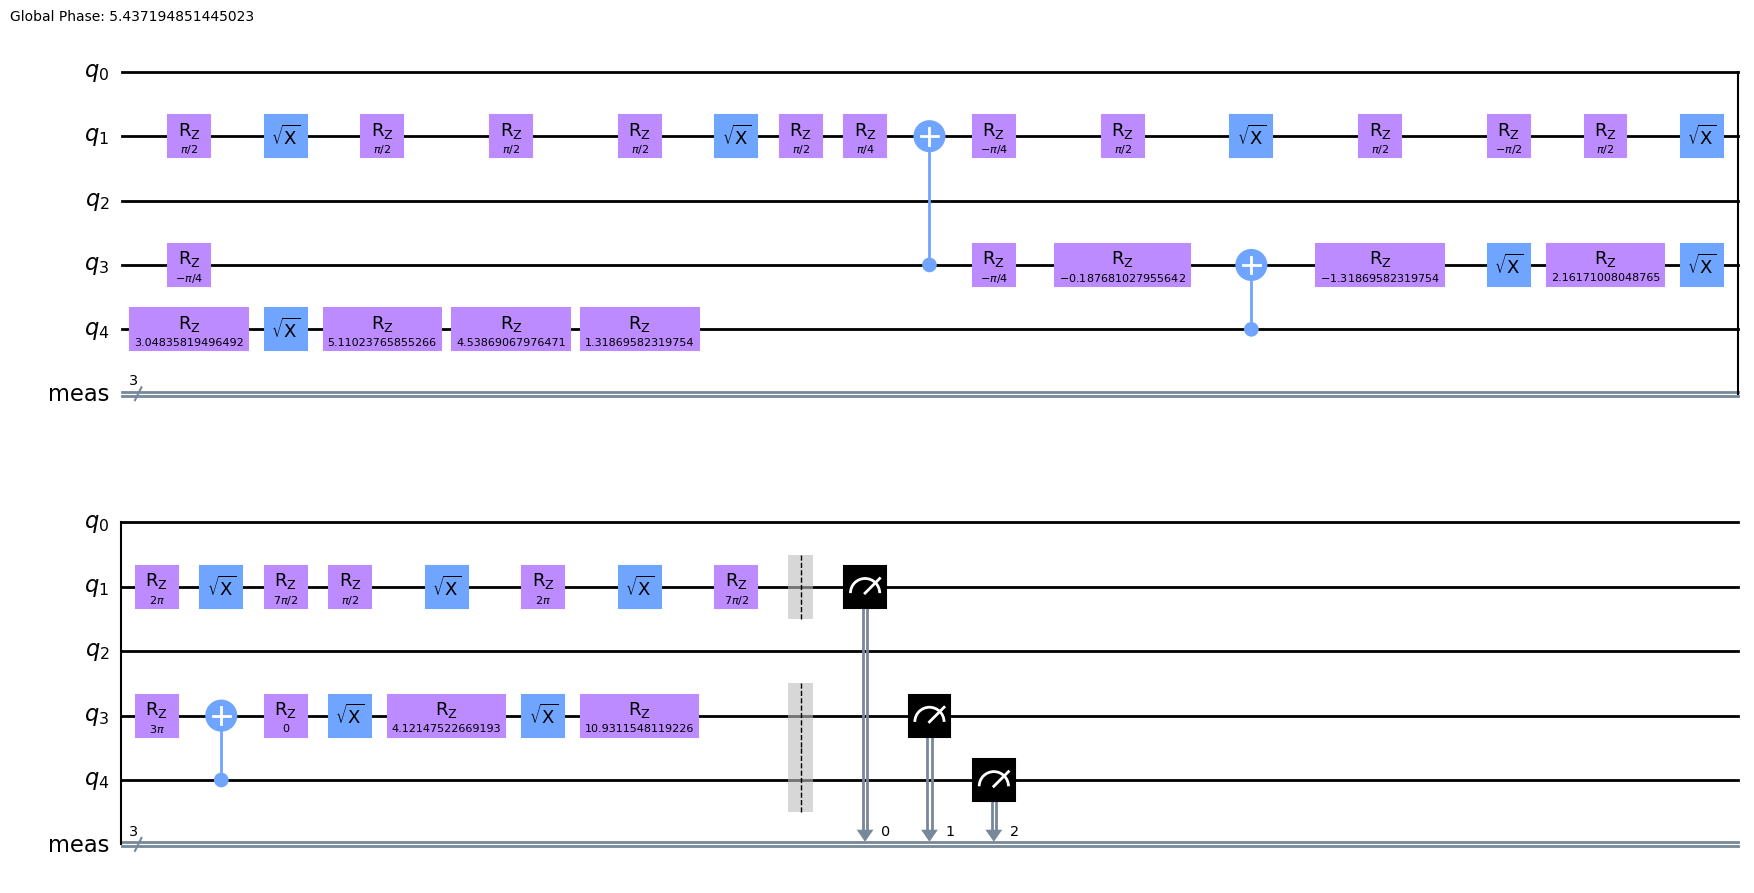

Circuit state after running <qiskit.transpiler.passes.utils.fixed_point.FixedPoint object at 0x7f8be49147c0>:


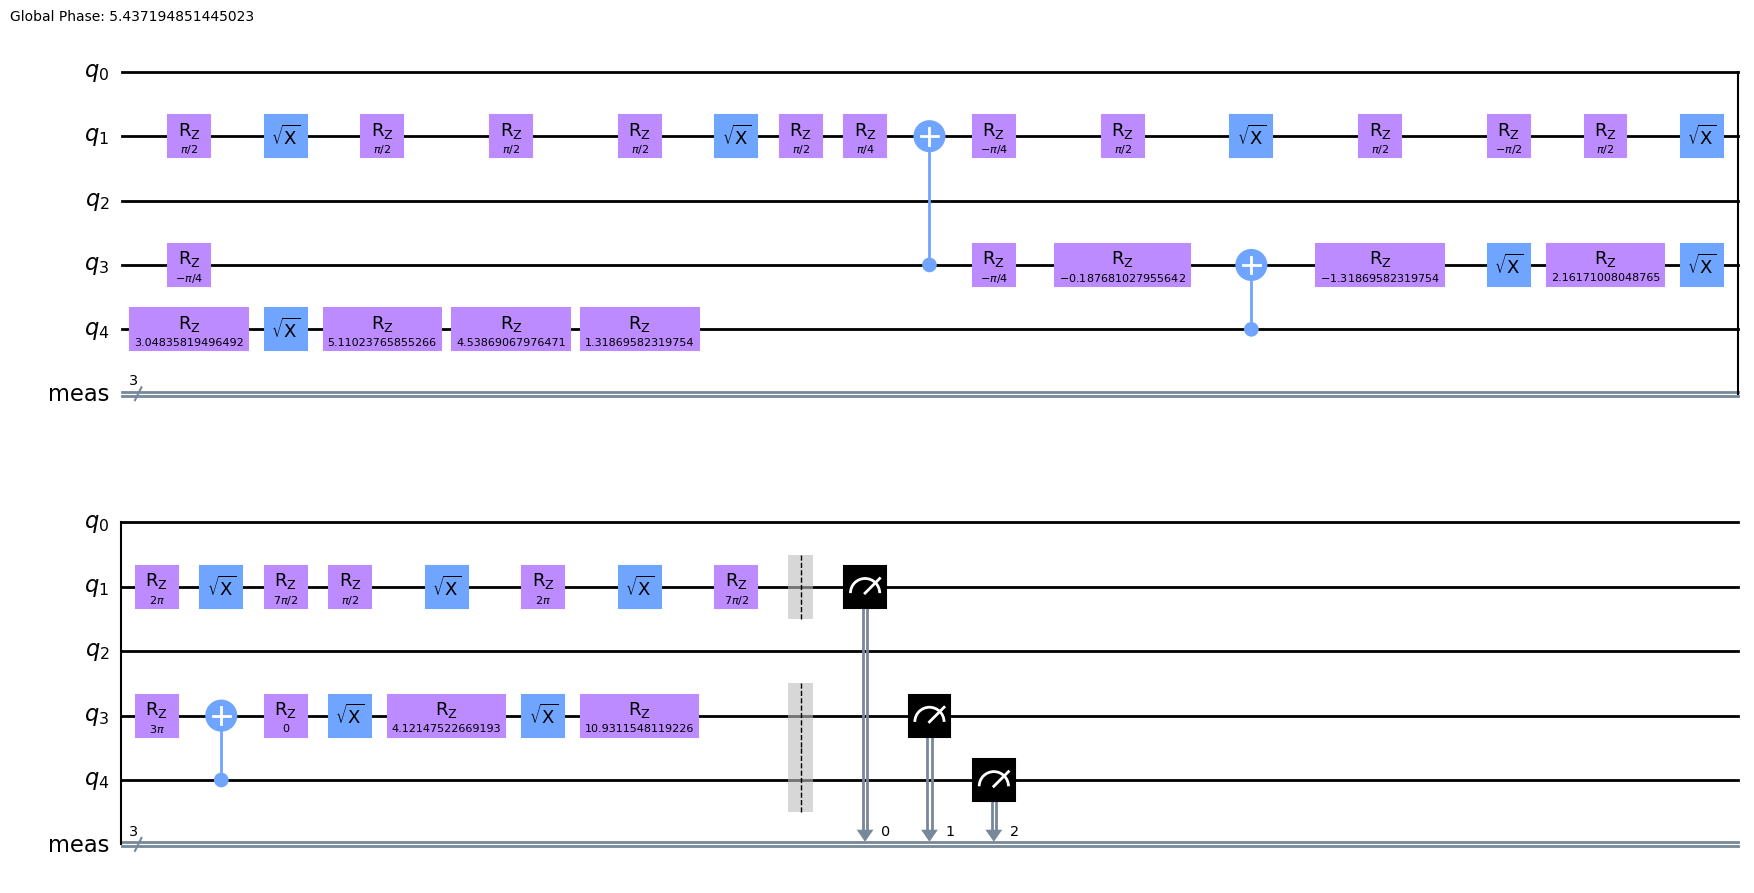

Circuit state after running <qiskit.transpiler.passes.analysis.size.Size object at 0x7f8be4915a50>:


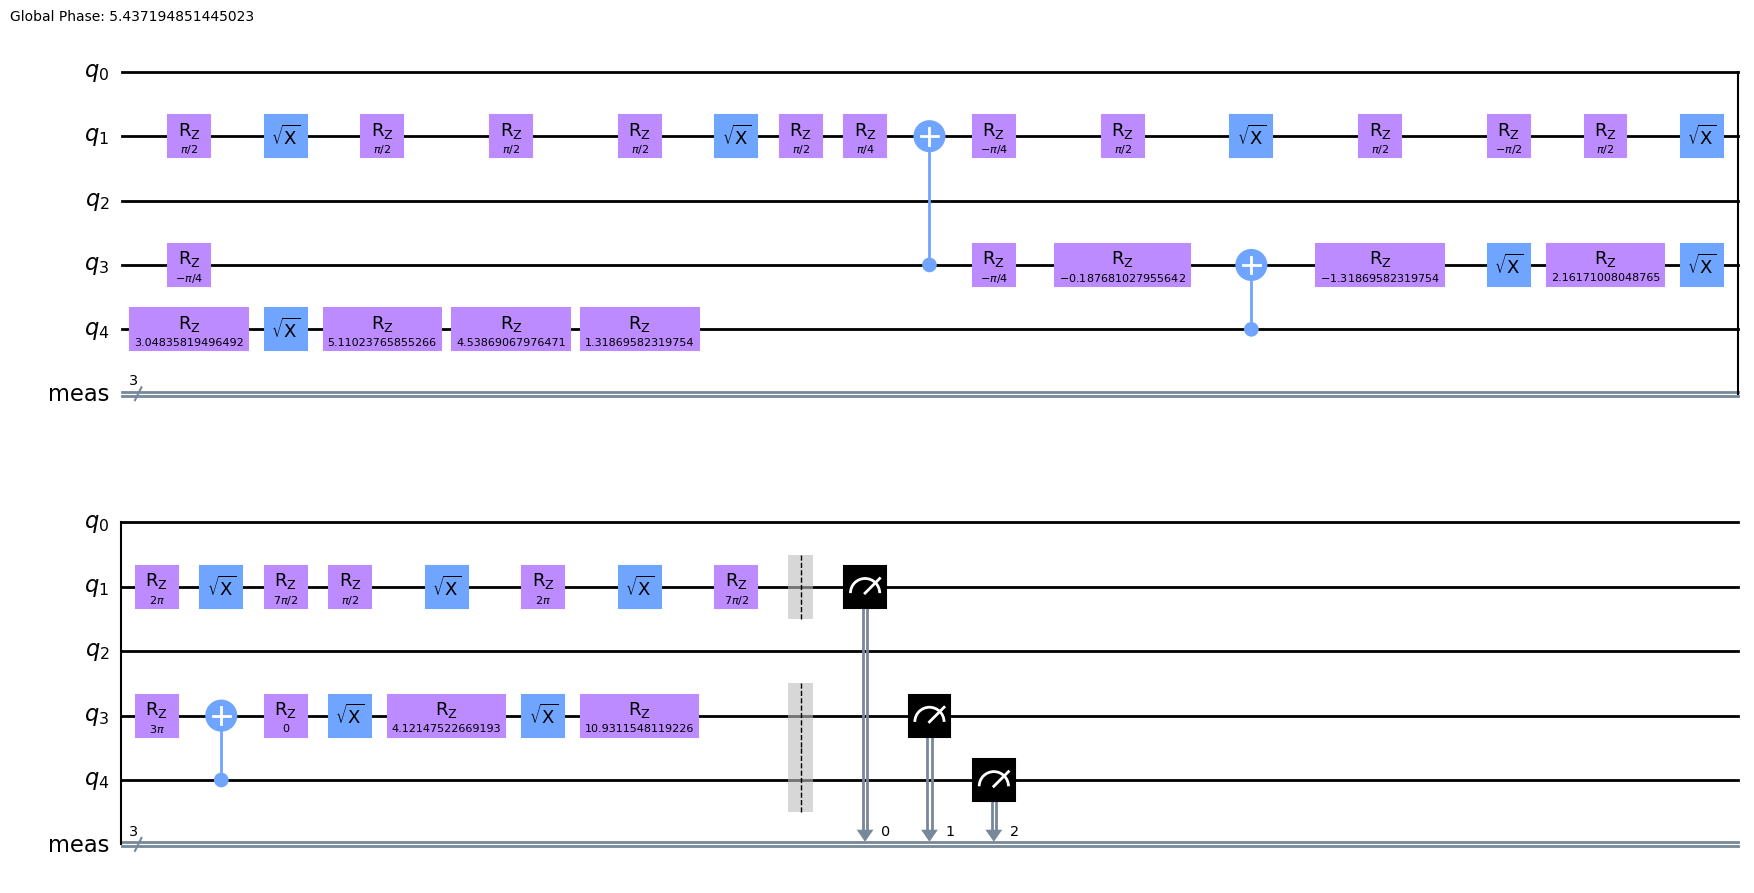

Circuit state after running <qiskit.transpiler.passes.utils.fixed_point.FixedPoint object at 0x7f8be4916170>:


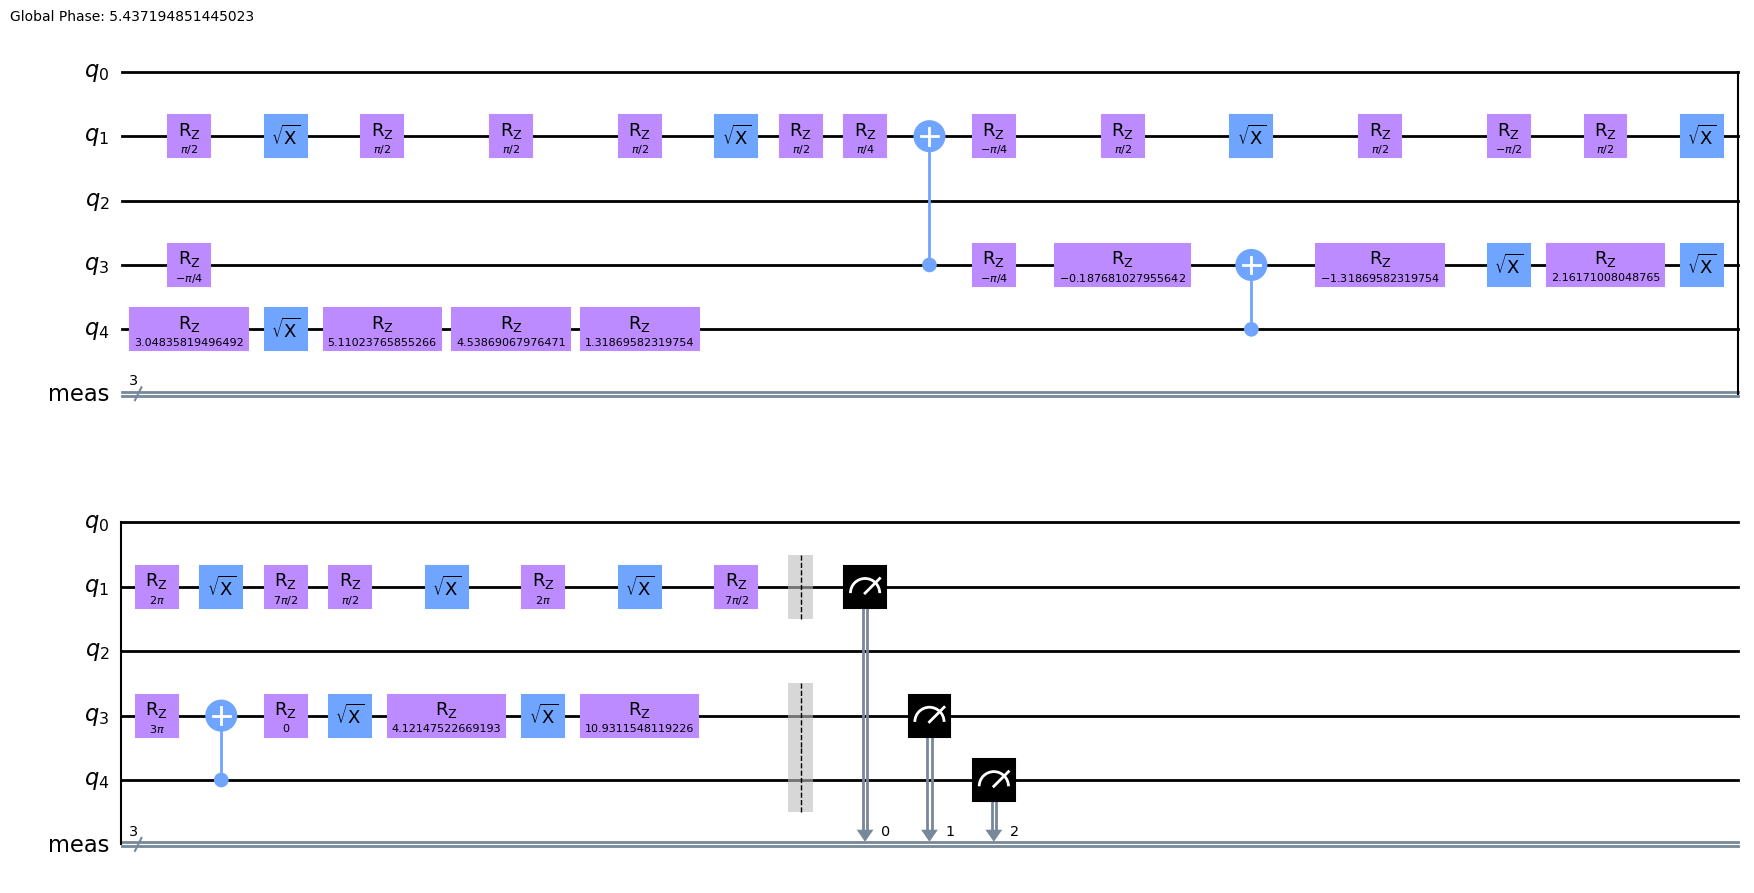

Circuit state after running <qiskit.transpiler.passes.optimization.optimize_1q_decomposition.Optimize1qGatesDecomposition object at 0x7f8be4916230>:


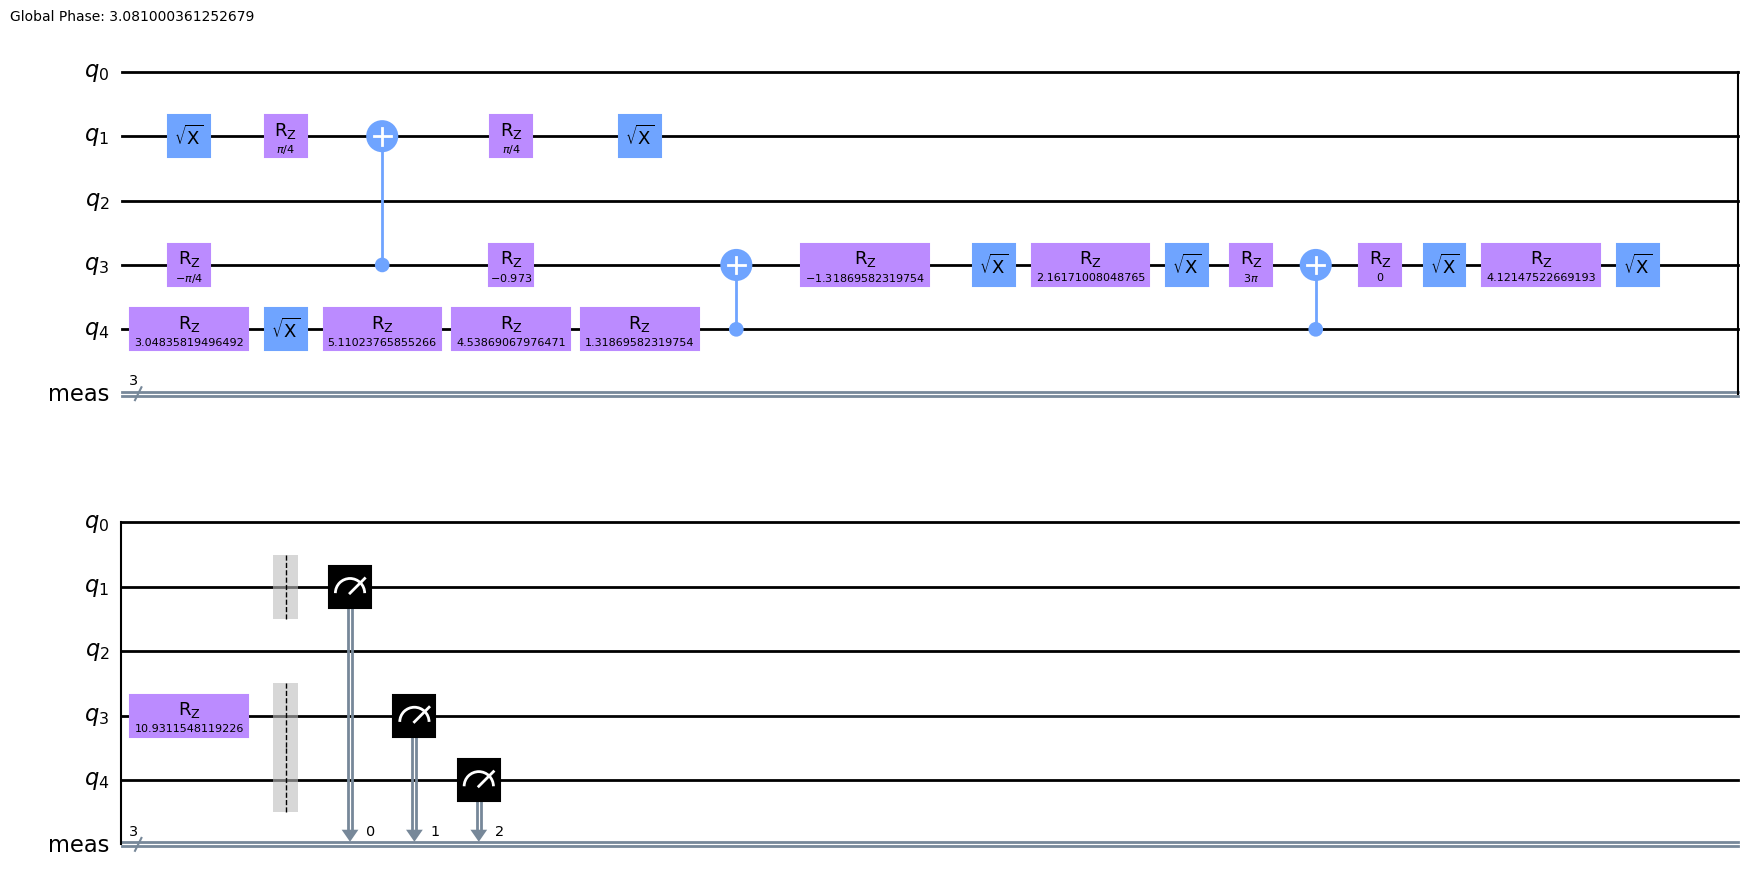

Circuit state after running <qiskit.transpiler.passes.optimization.cx_cancellation.CXCancellation object at 0x7f8be49161d0>:


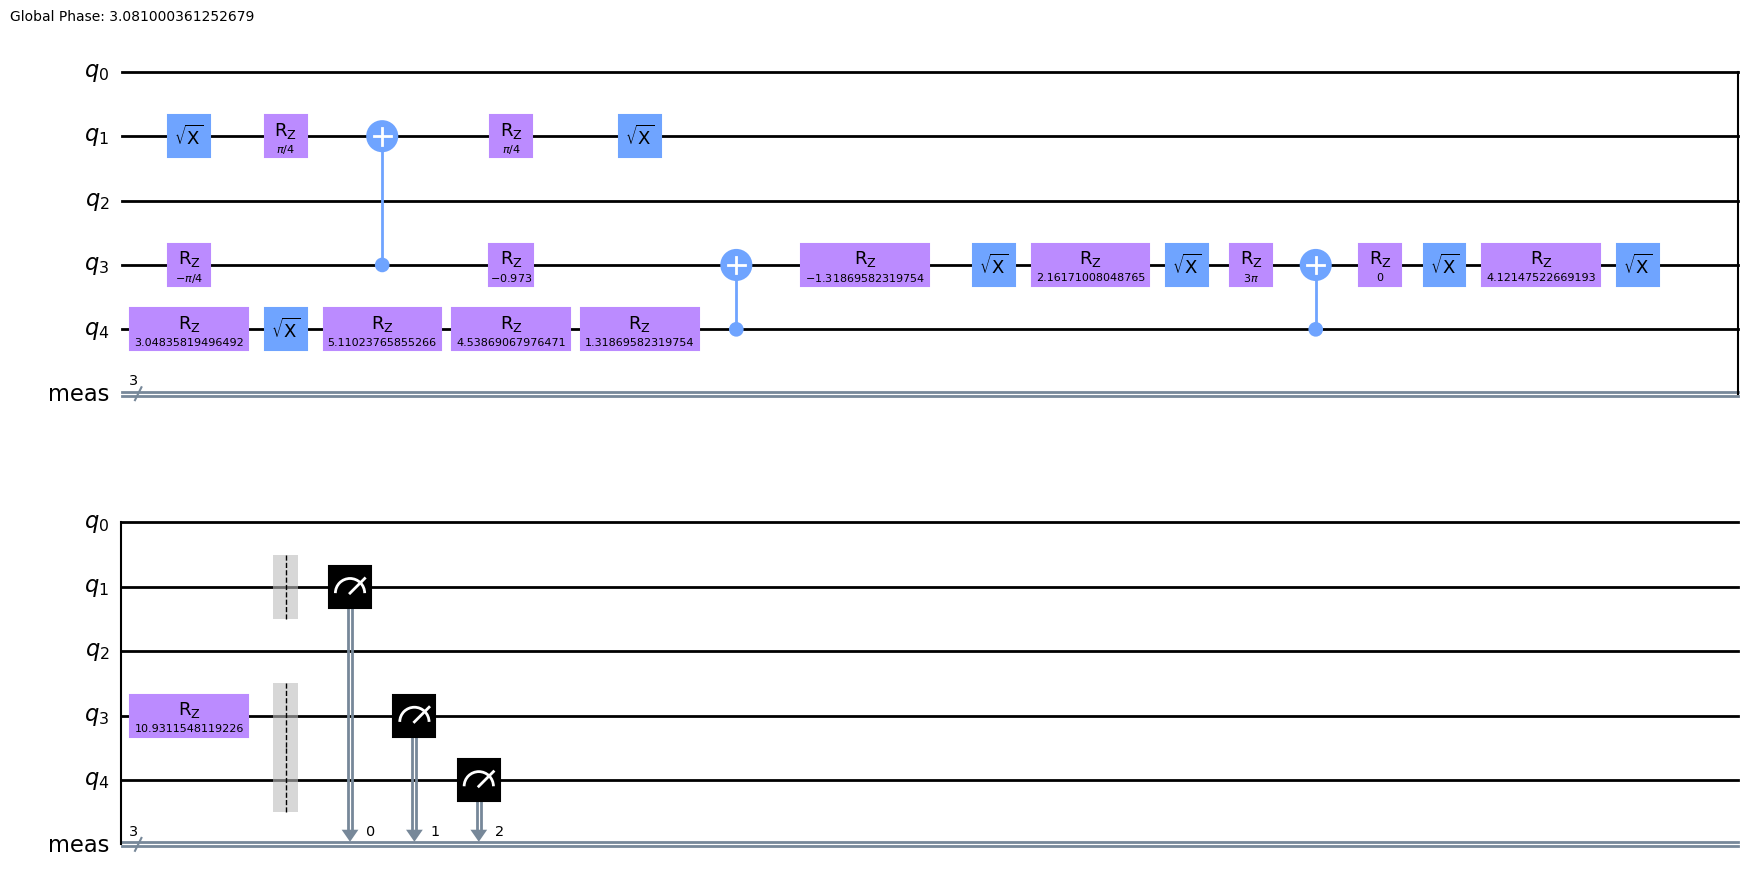

Circuit state after running <qiskit.transpiler.passes.utils.gates_basis.GatesInBasis object at 0x7f8be4914910>:


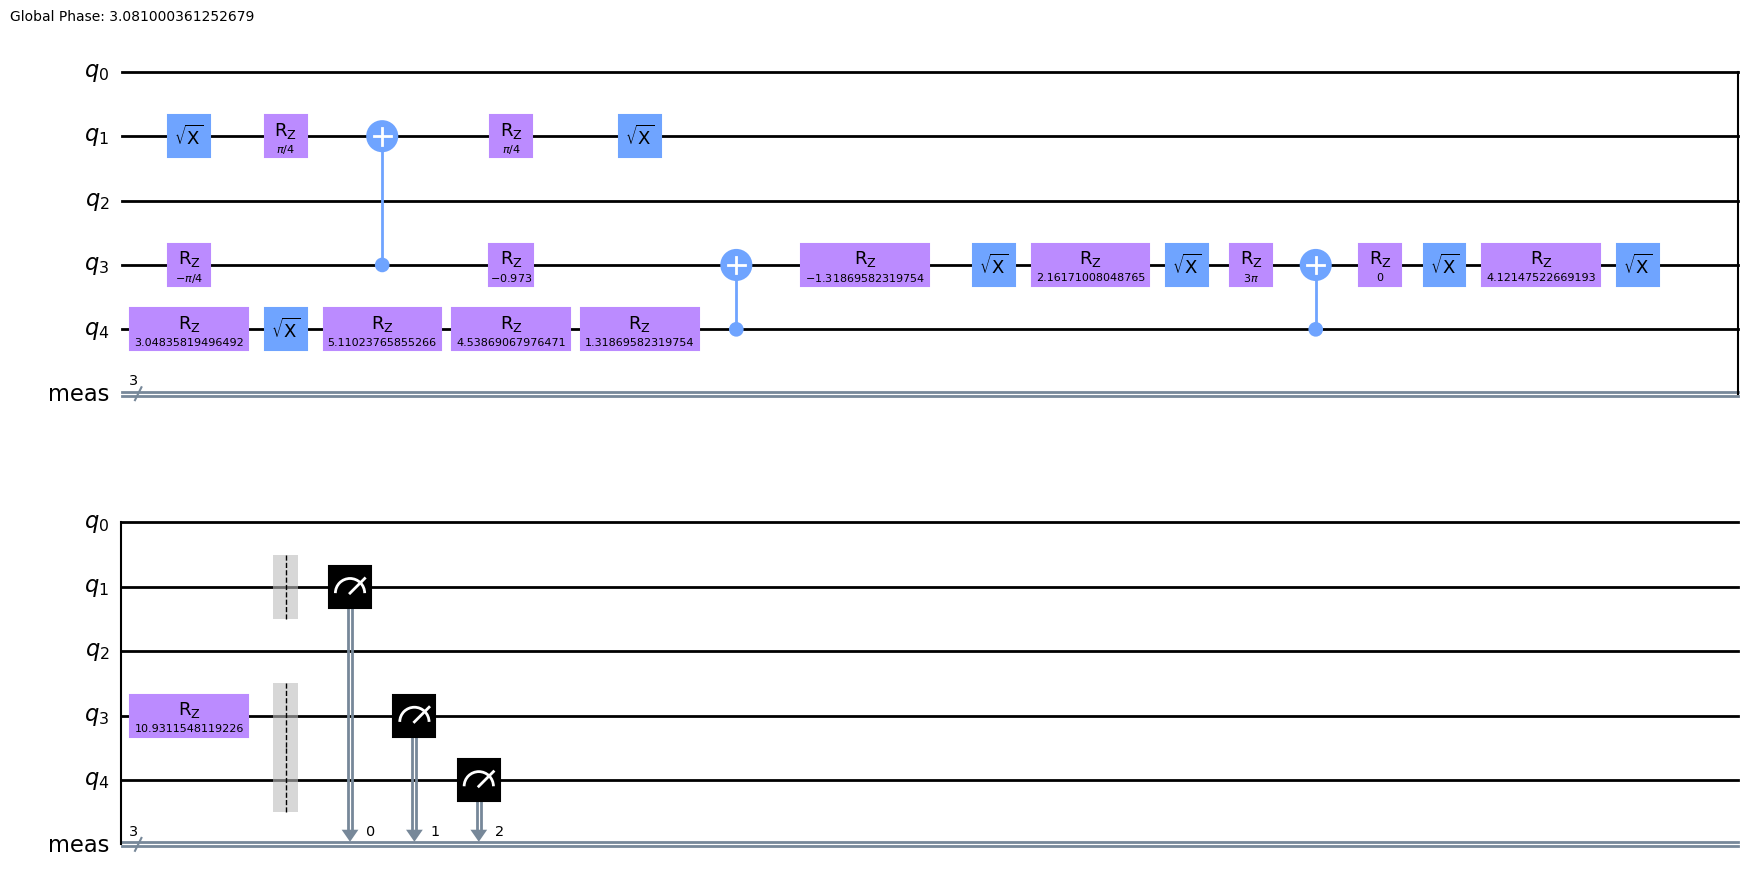

Circuit state after running <qiskit.transpiler.passes.analysis.depth.Depth object at 0x7f8be4917280>:


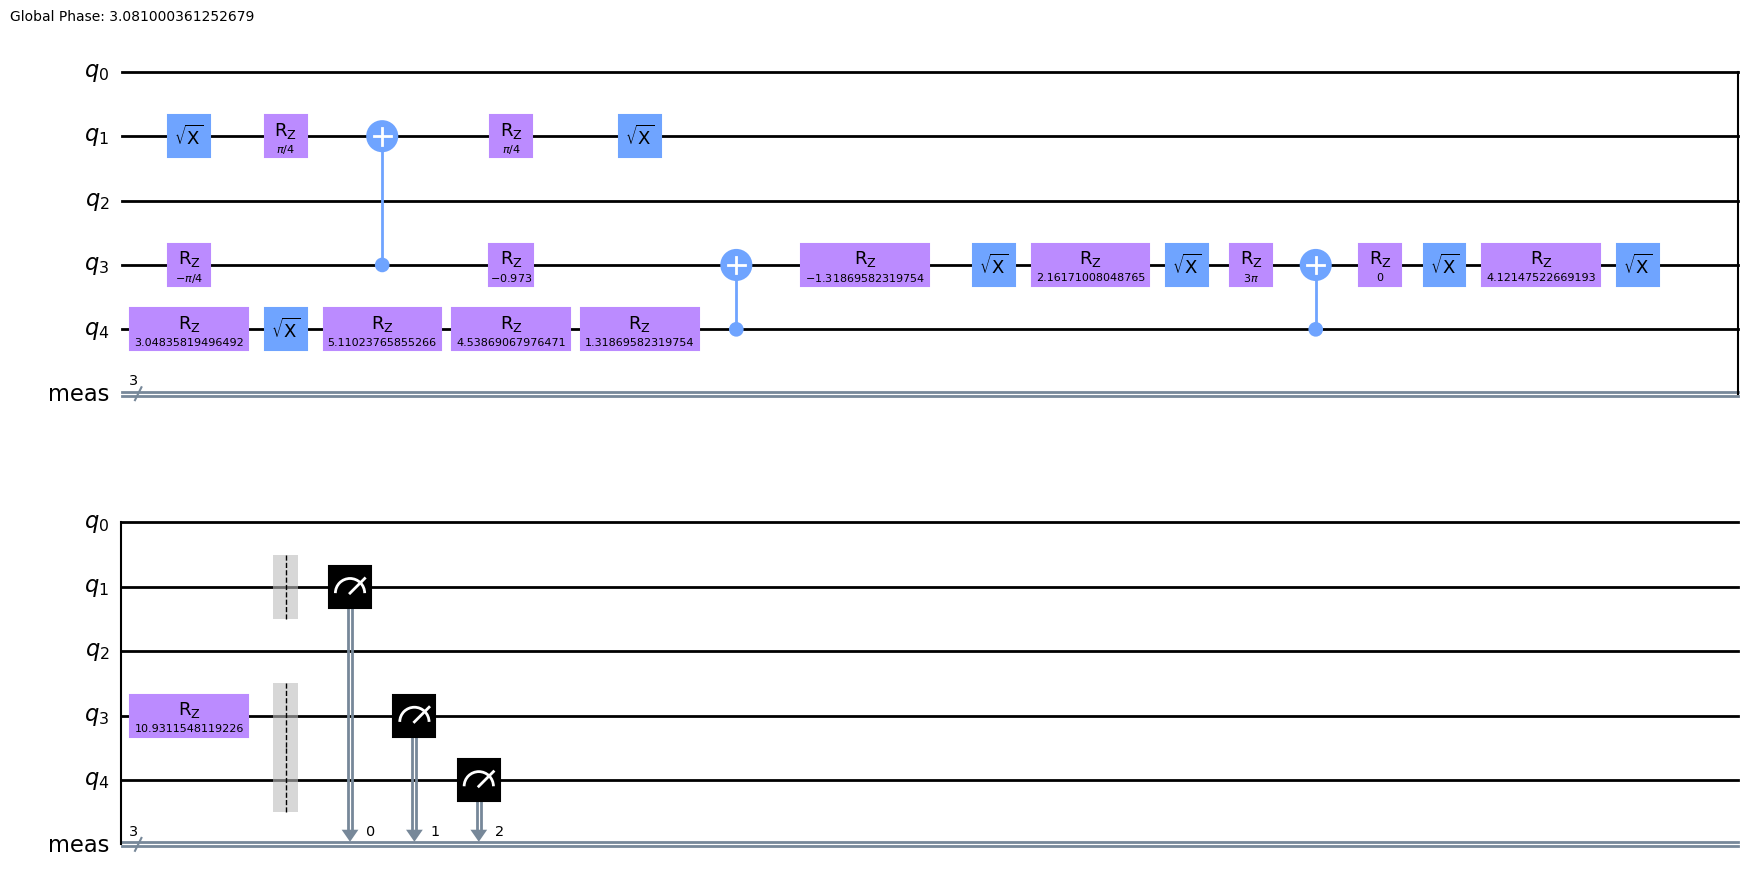

Circuit state after running <qiskit.transpiler.passes.utils.fixed_point.FixedPoint object at 0x7f8be49147c0>:


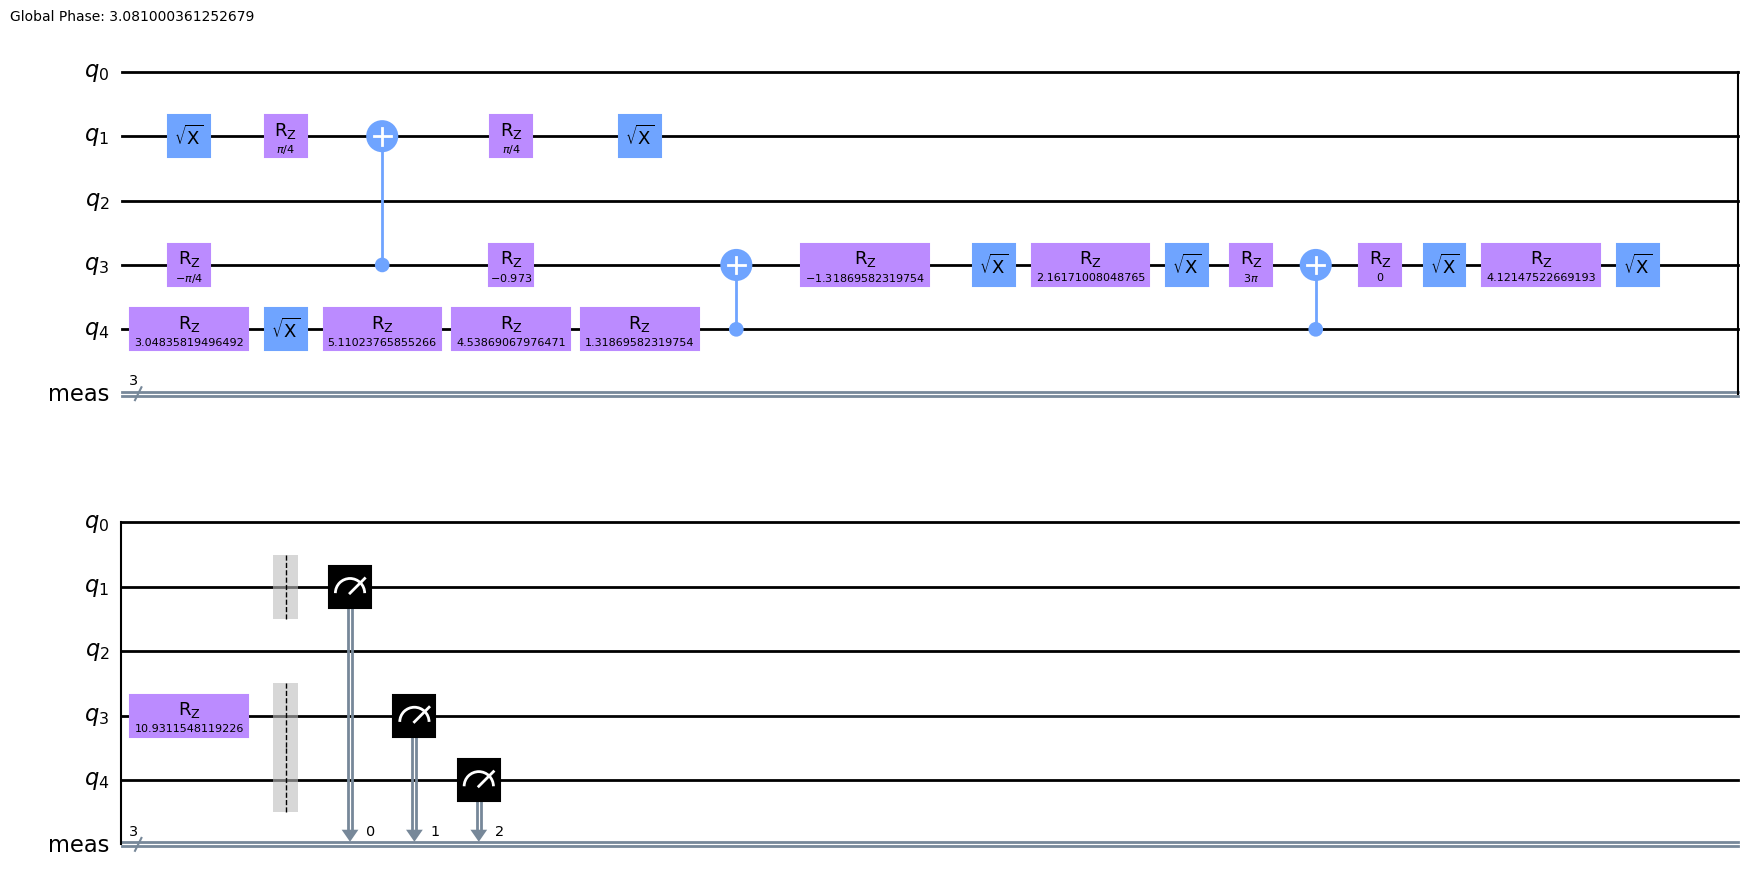

Circuit state after running <qiskit.transpiler.passes.analysis.size.Size object at 0x7f8be4915a50>:


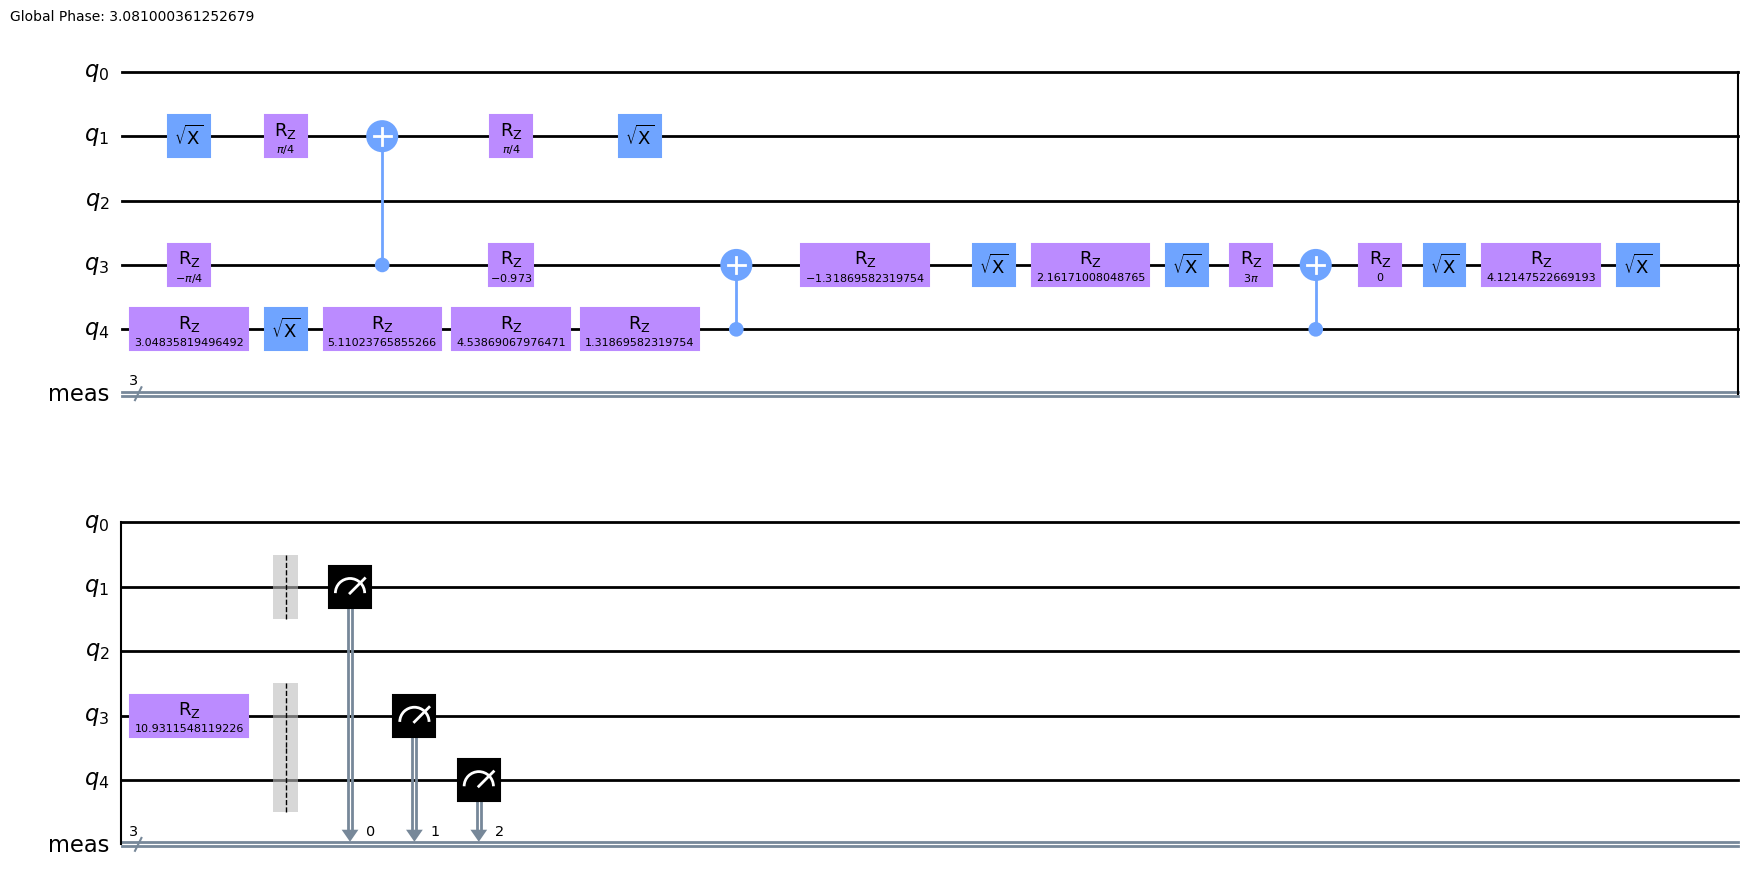

Circuit state after running <qiskit.transpiler.passes.utils.fixed_point.FixedPoint object at 0x7f8be4916170>:


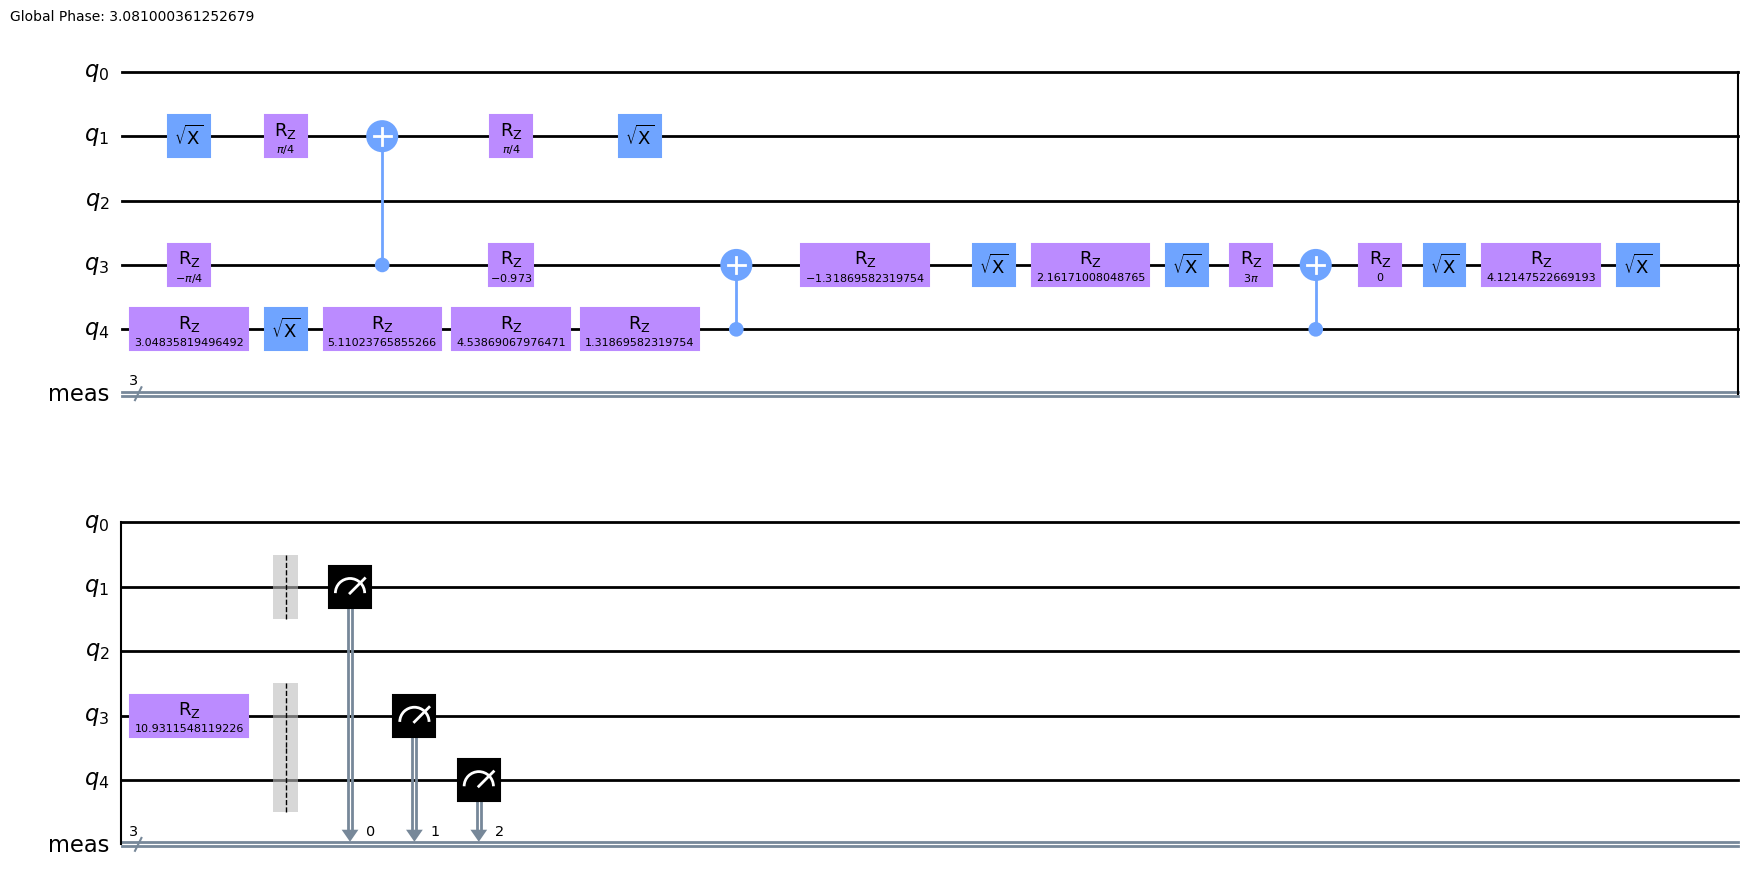

Circuit state after running <qiskit.transpiler.passes.optimization.optimize_1q_decomposition.Optimize1qGatesDecomposition object at 0x7f8be4916230>:


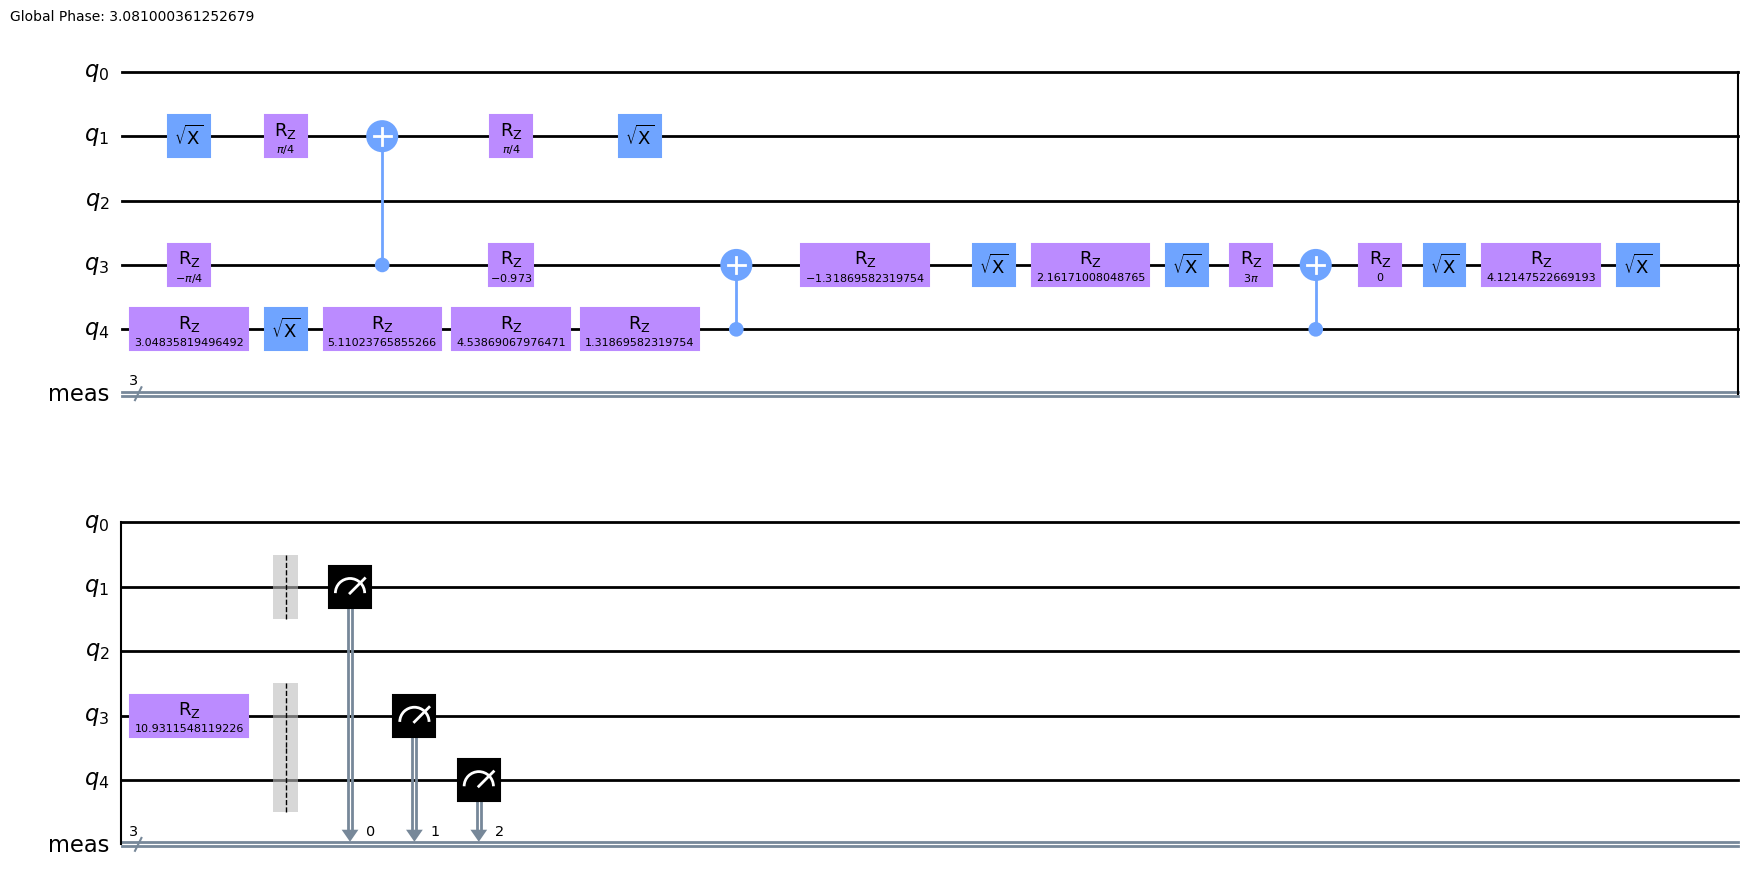

Circuit state after running <qiskit.transpiler.passes.optimization.cx_cancellation.CXCancellation object at 0x7f8be49161d0>:


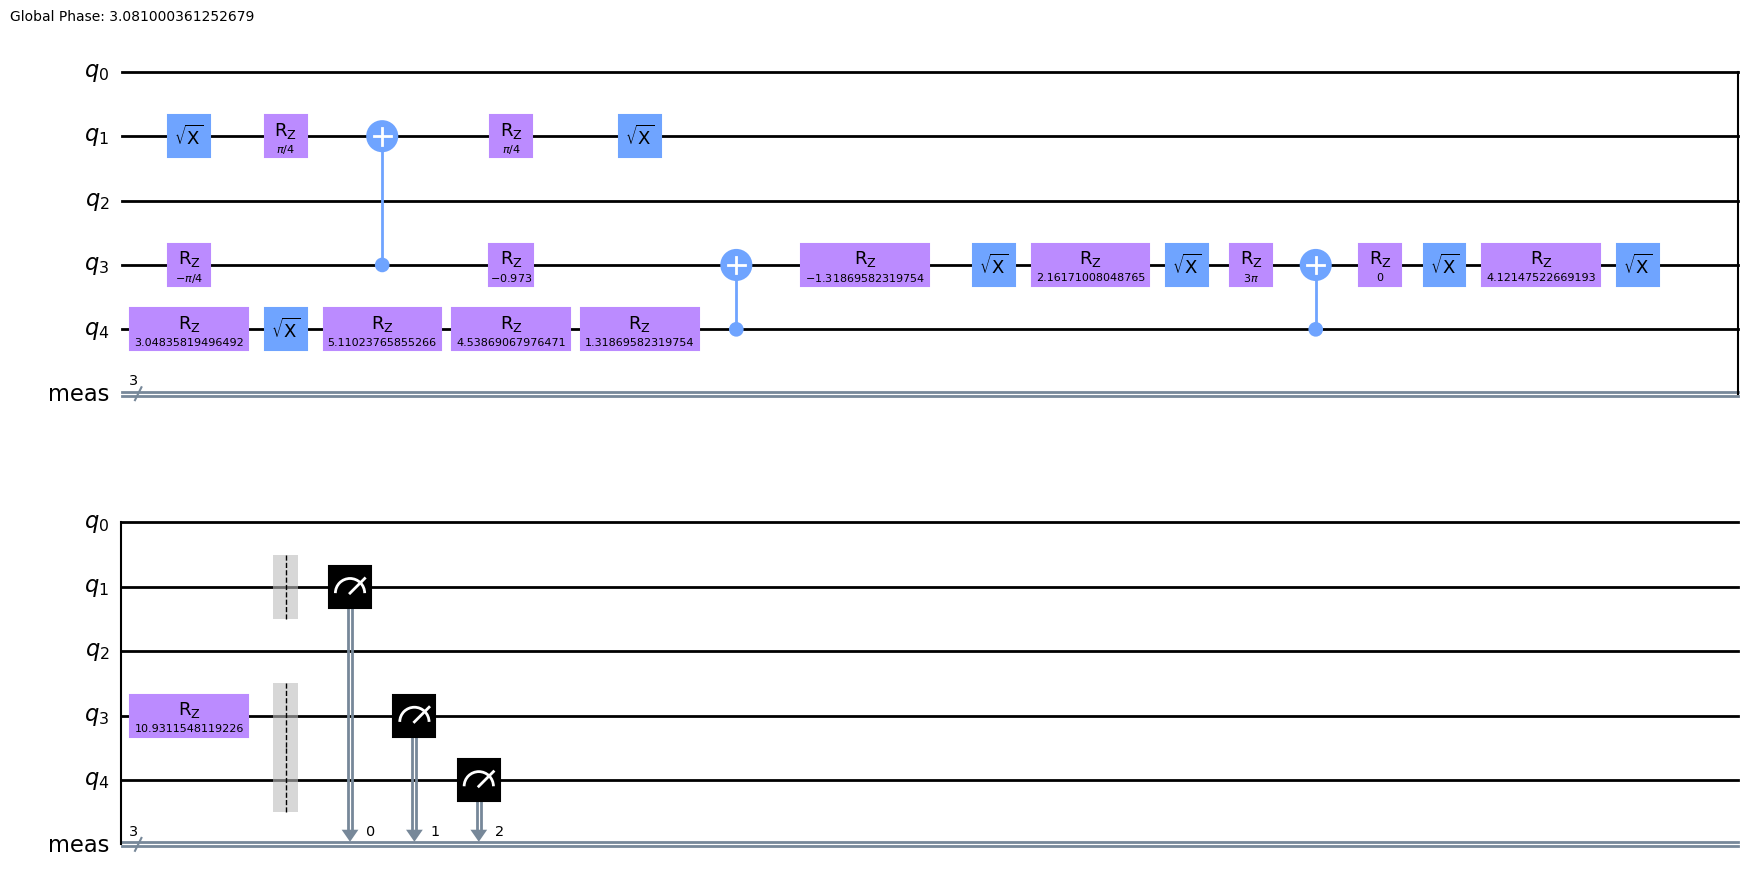

Circuit state after running <qiskit.transpiler.passes.utils.gates_basis.GatesInBasis object at 0x7f8be4914910>:


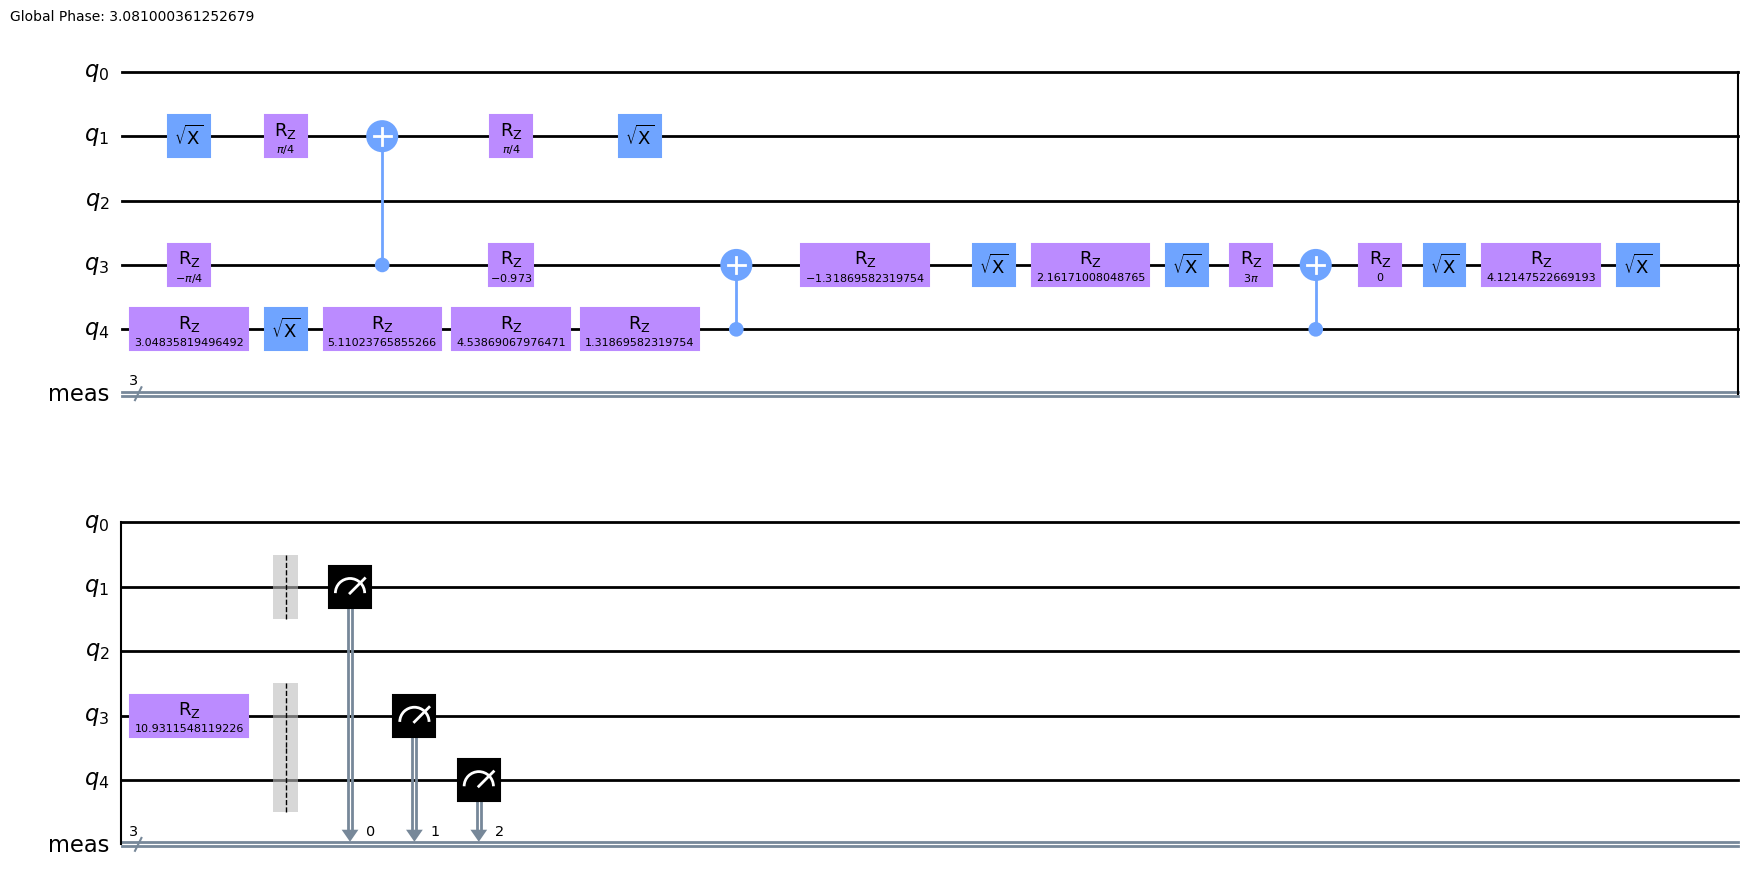

Circuit state after running <qiskit.transpiler.passes.analysis.depth.Depth object at 0x7f8be4917280>:


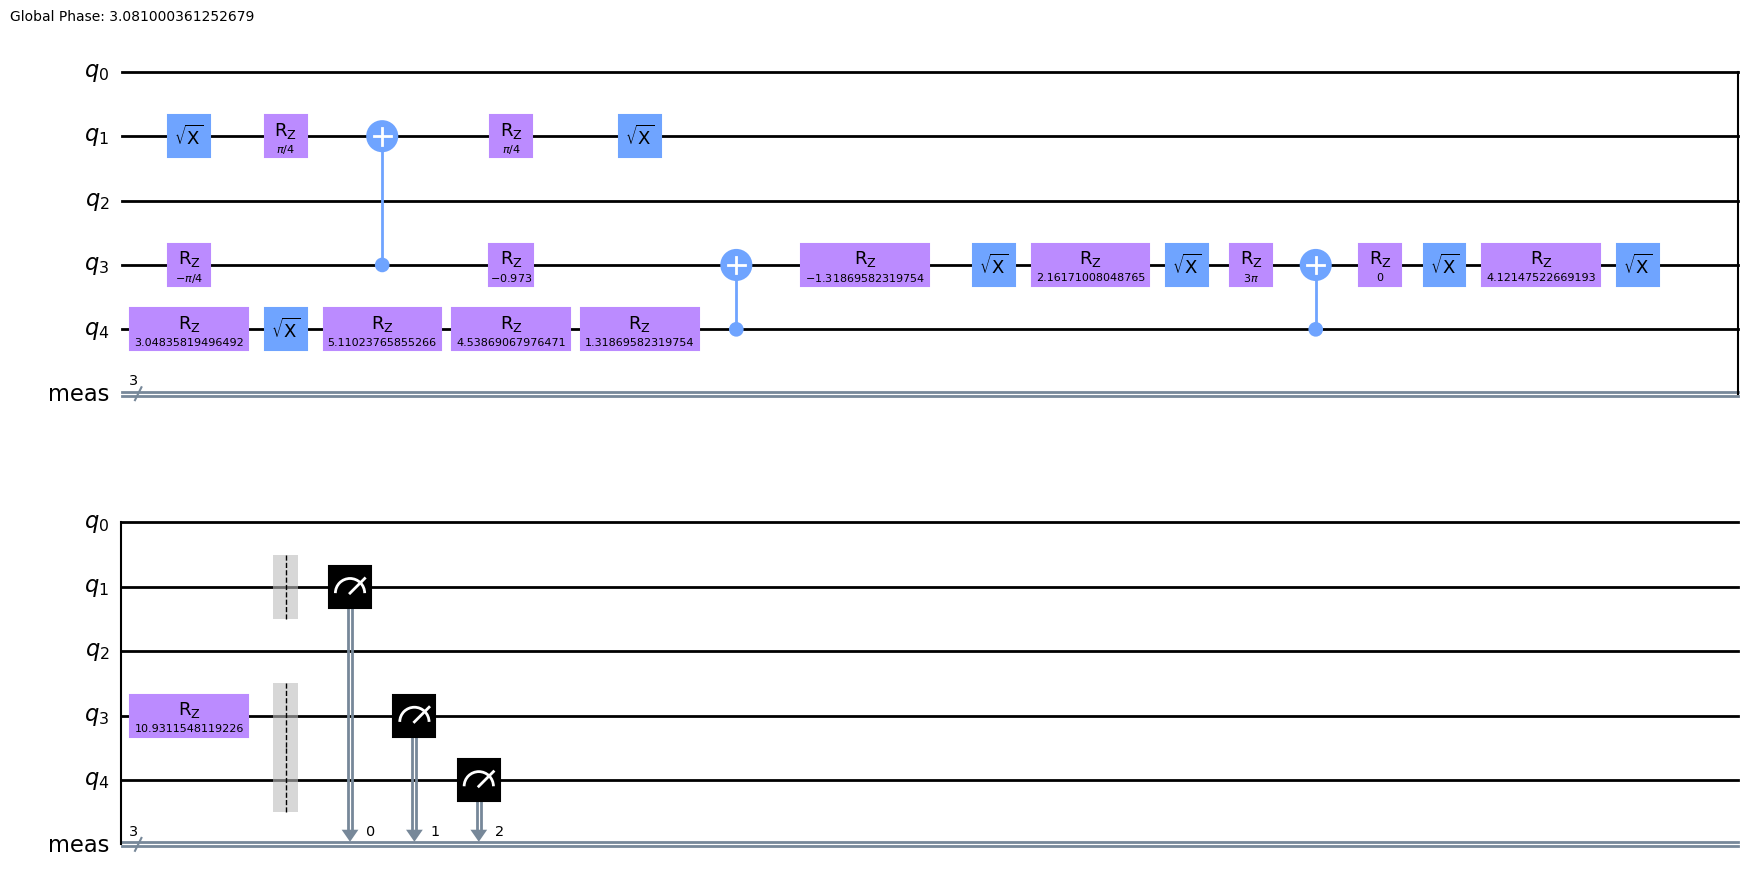

Circuit state after running <qiskit.transpiler.passes.utils.fixed_point.FixedPoint object at 0x7f8be49147c0>:


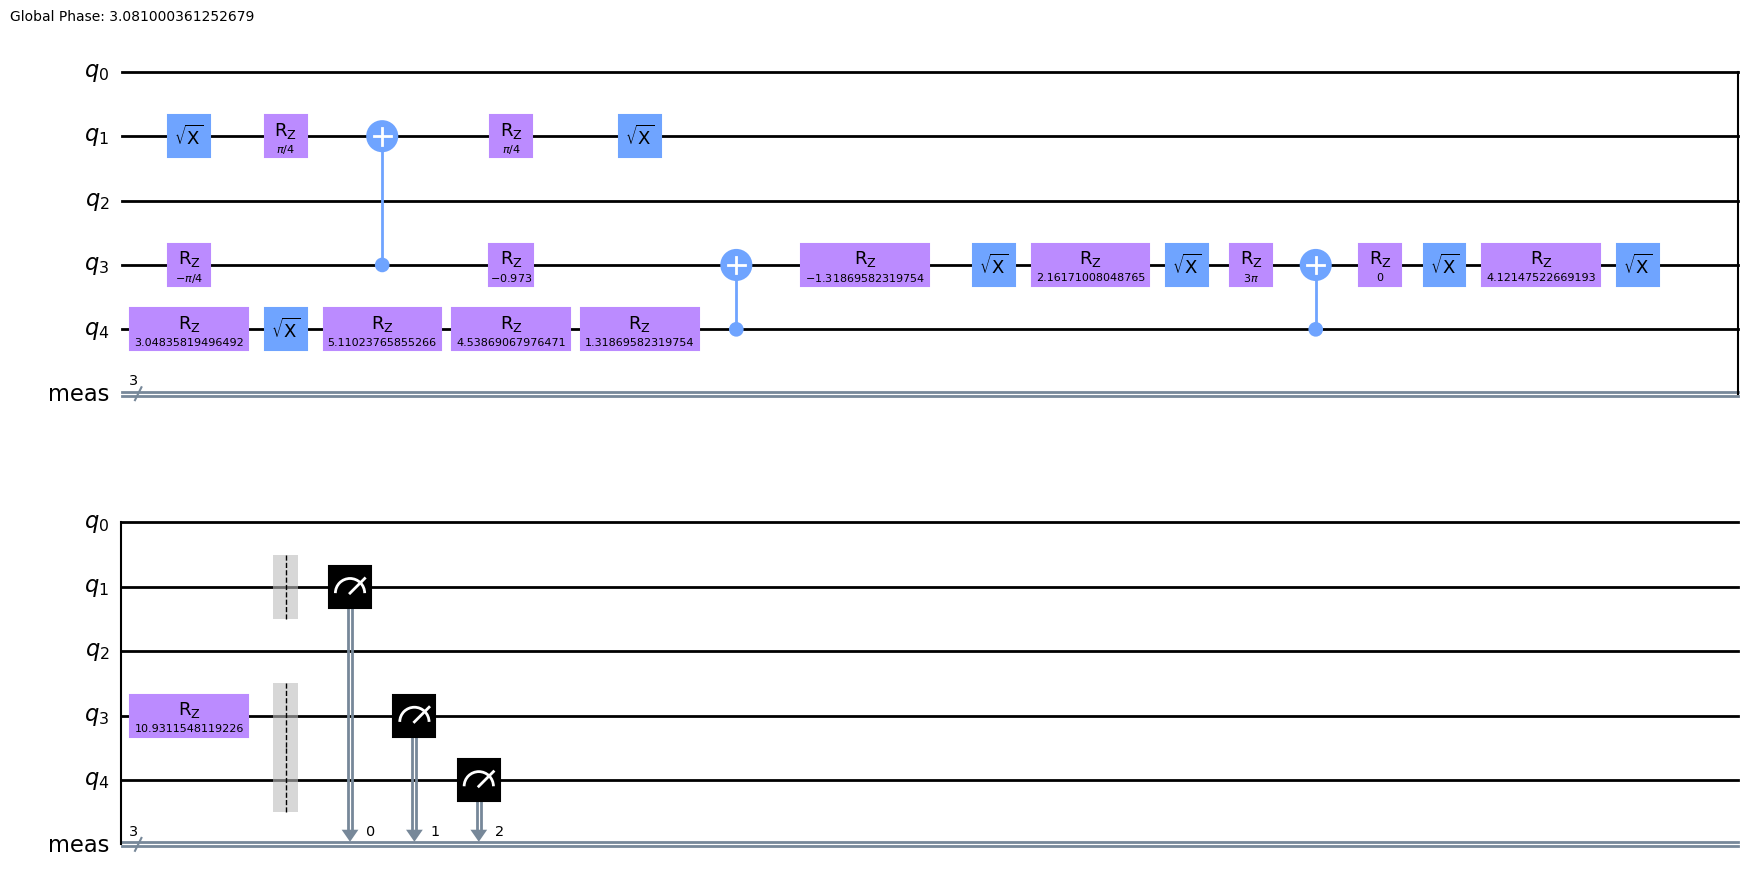

Circuit state after running <qiskit.transpiler.passes.analysis.size.Size object at 0x7f8be4915a50>:


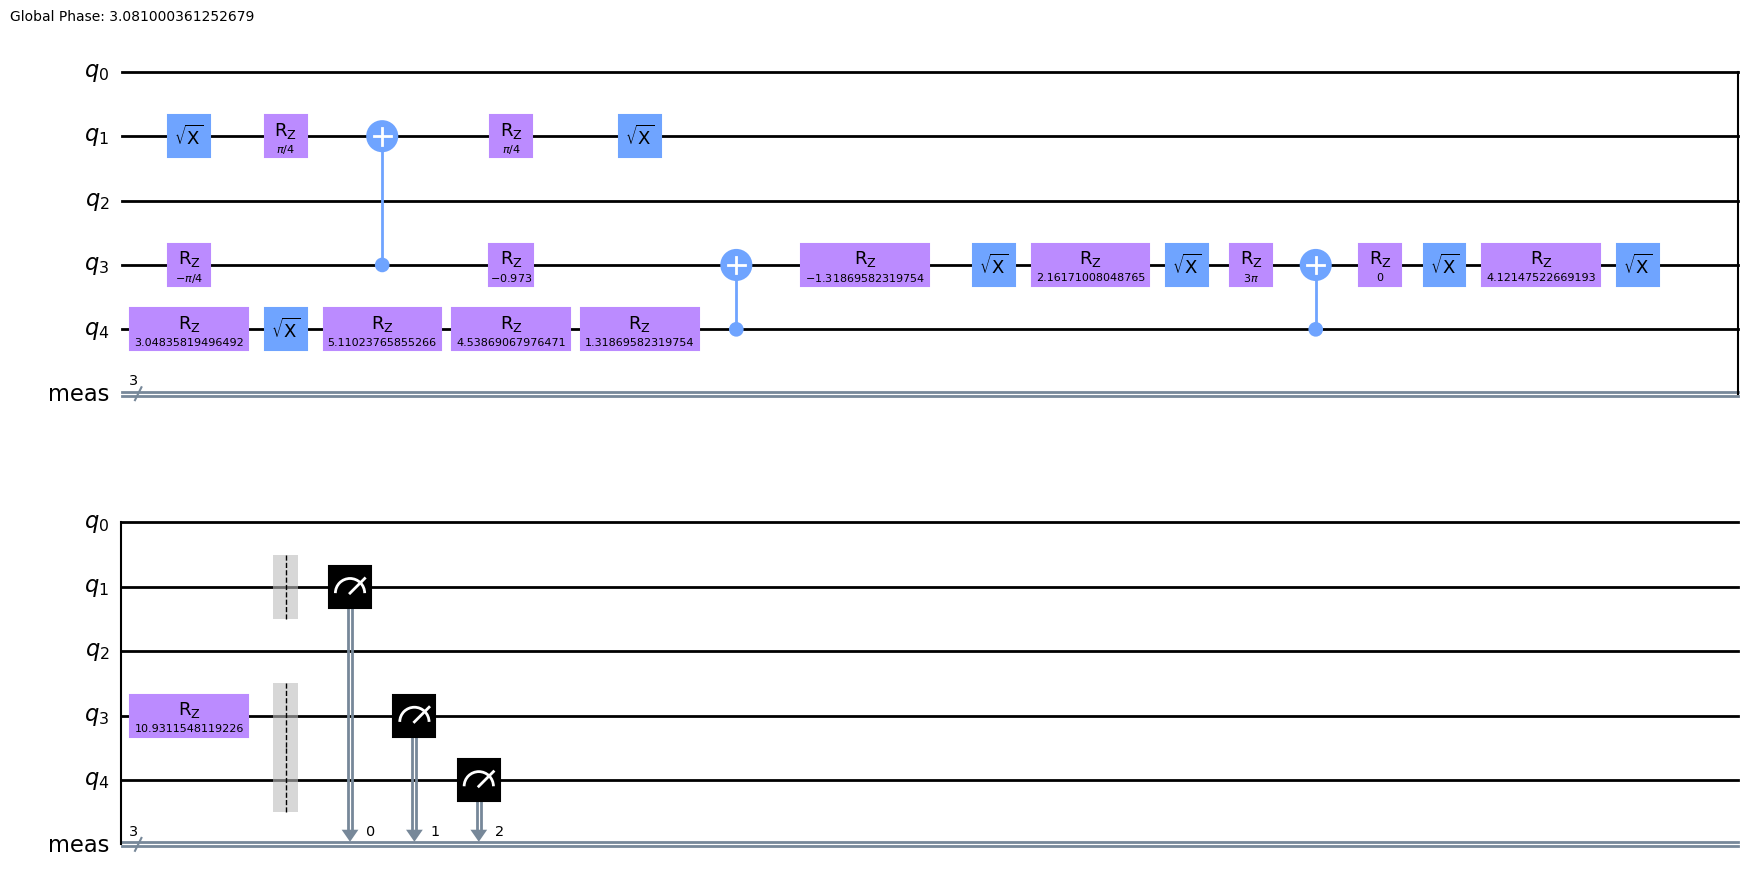

Circuit state after running <qiskit.transpiler.passes.utils.fixed_point.FixedPoint object at 0x7f8be4916170>:


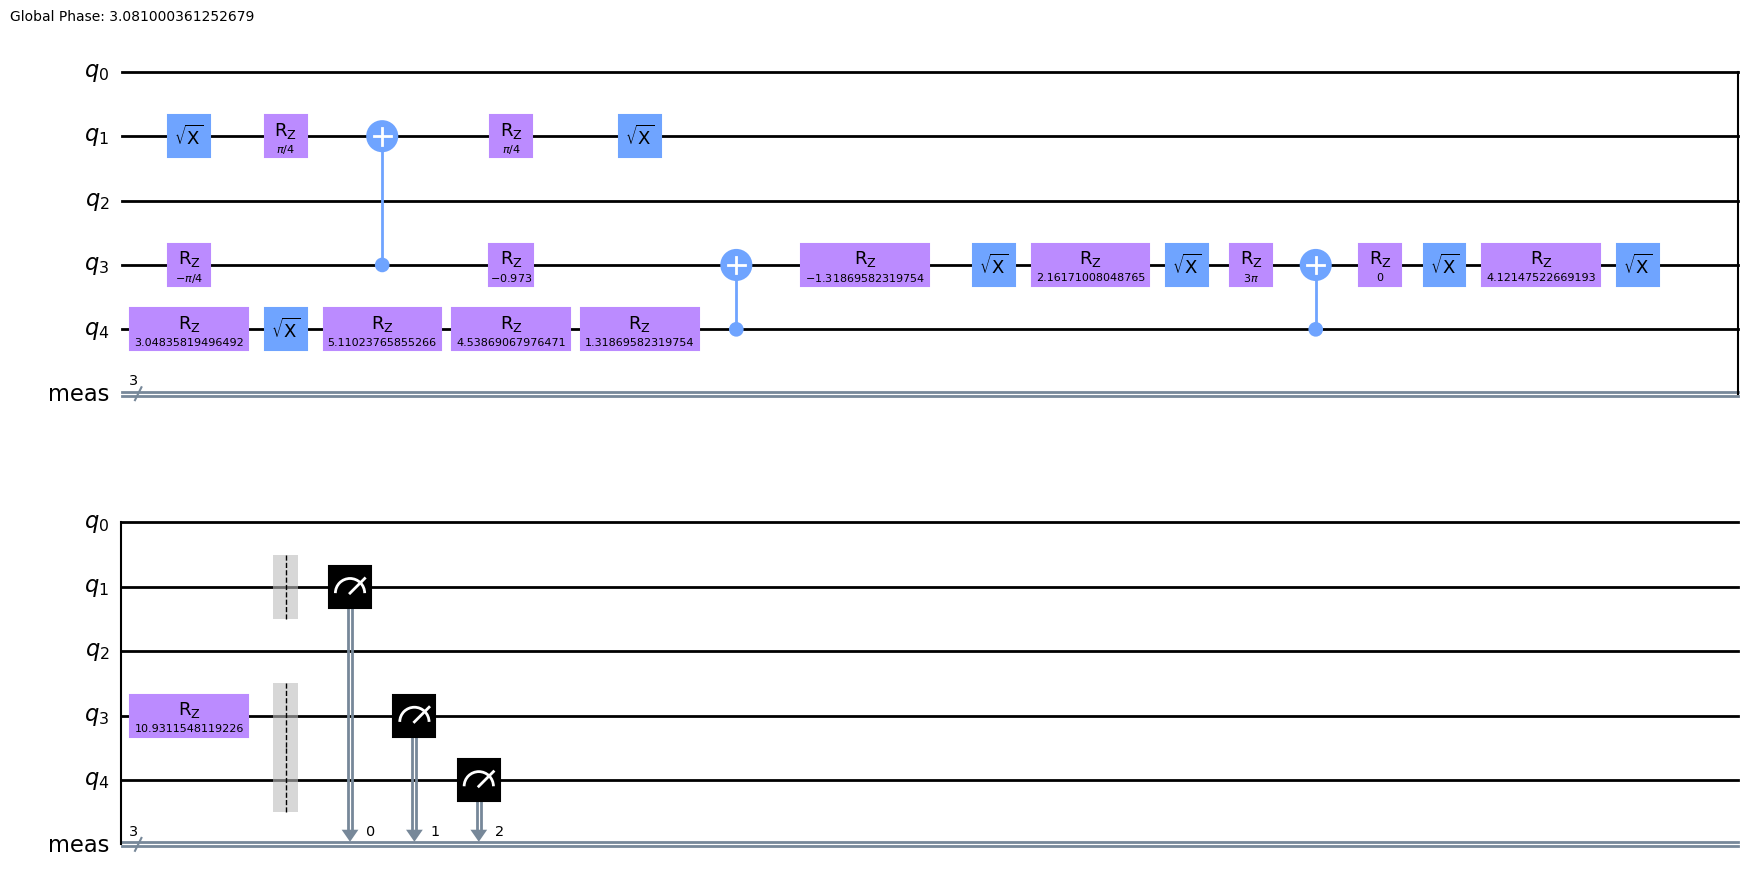

Circuit state after running <qiskit.transpiler.passes.scheduling.time_unit_conversion.TimeUnitConversion object at 0x7f8be47ca320>:


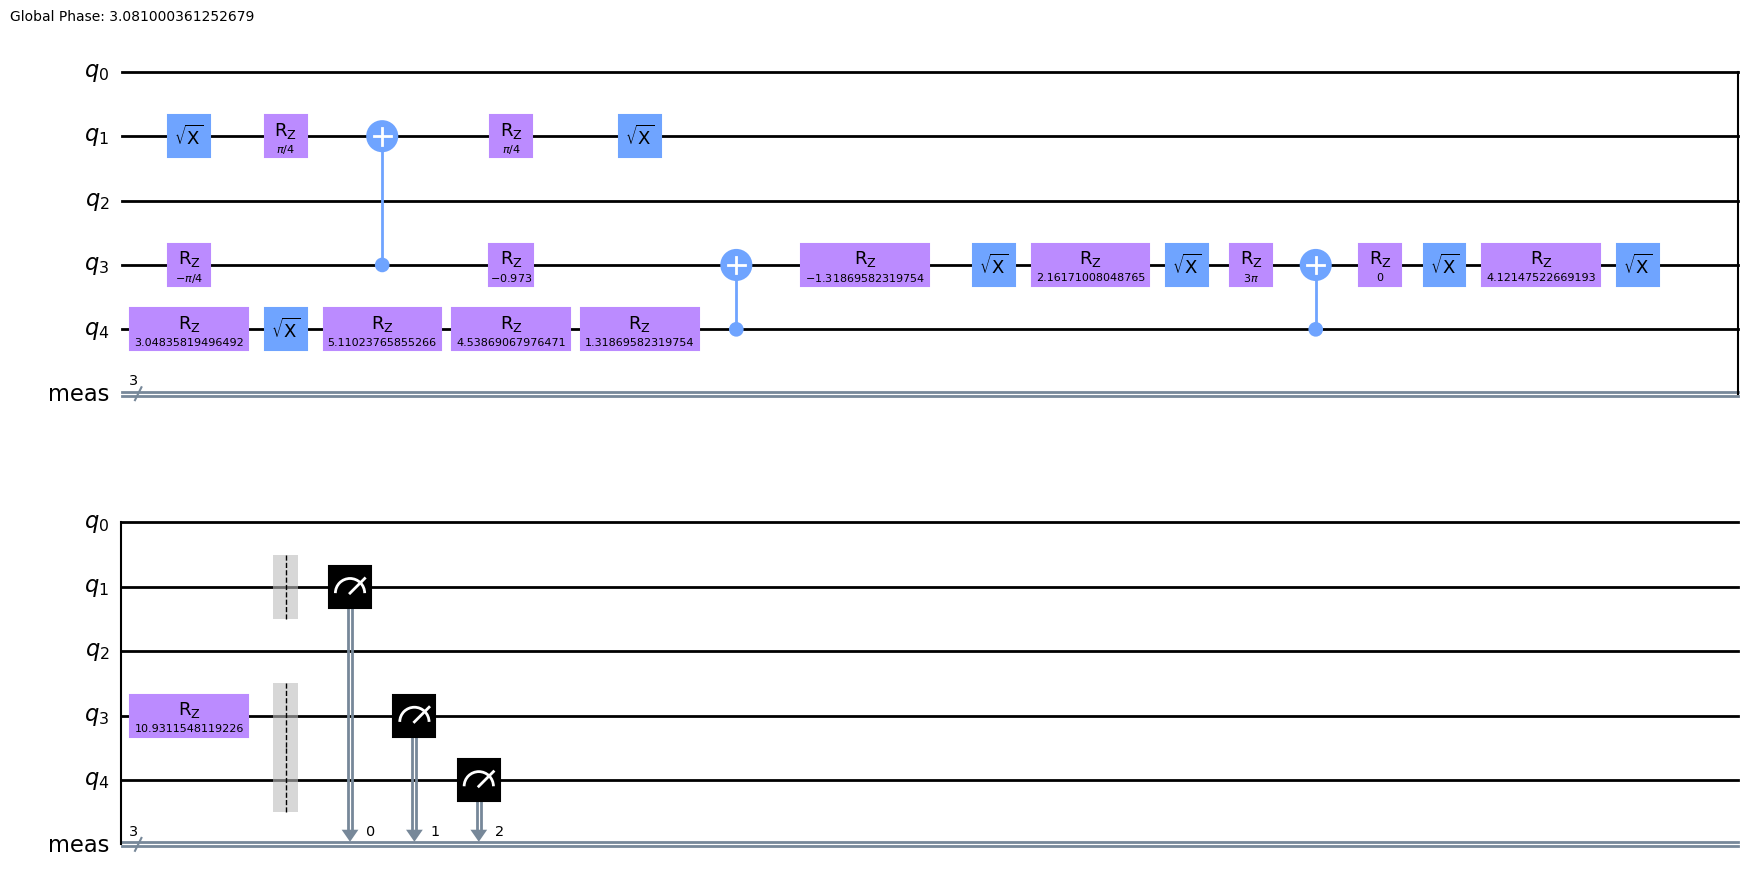

Circuit state after running <qiskit.transpiler.passes.scheduling.scheduling.alap.ALAPScheduleAnalysis object at 0x7f8be47c9a20>:


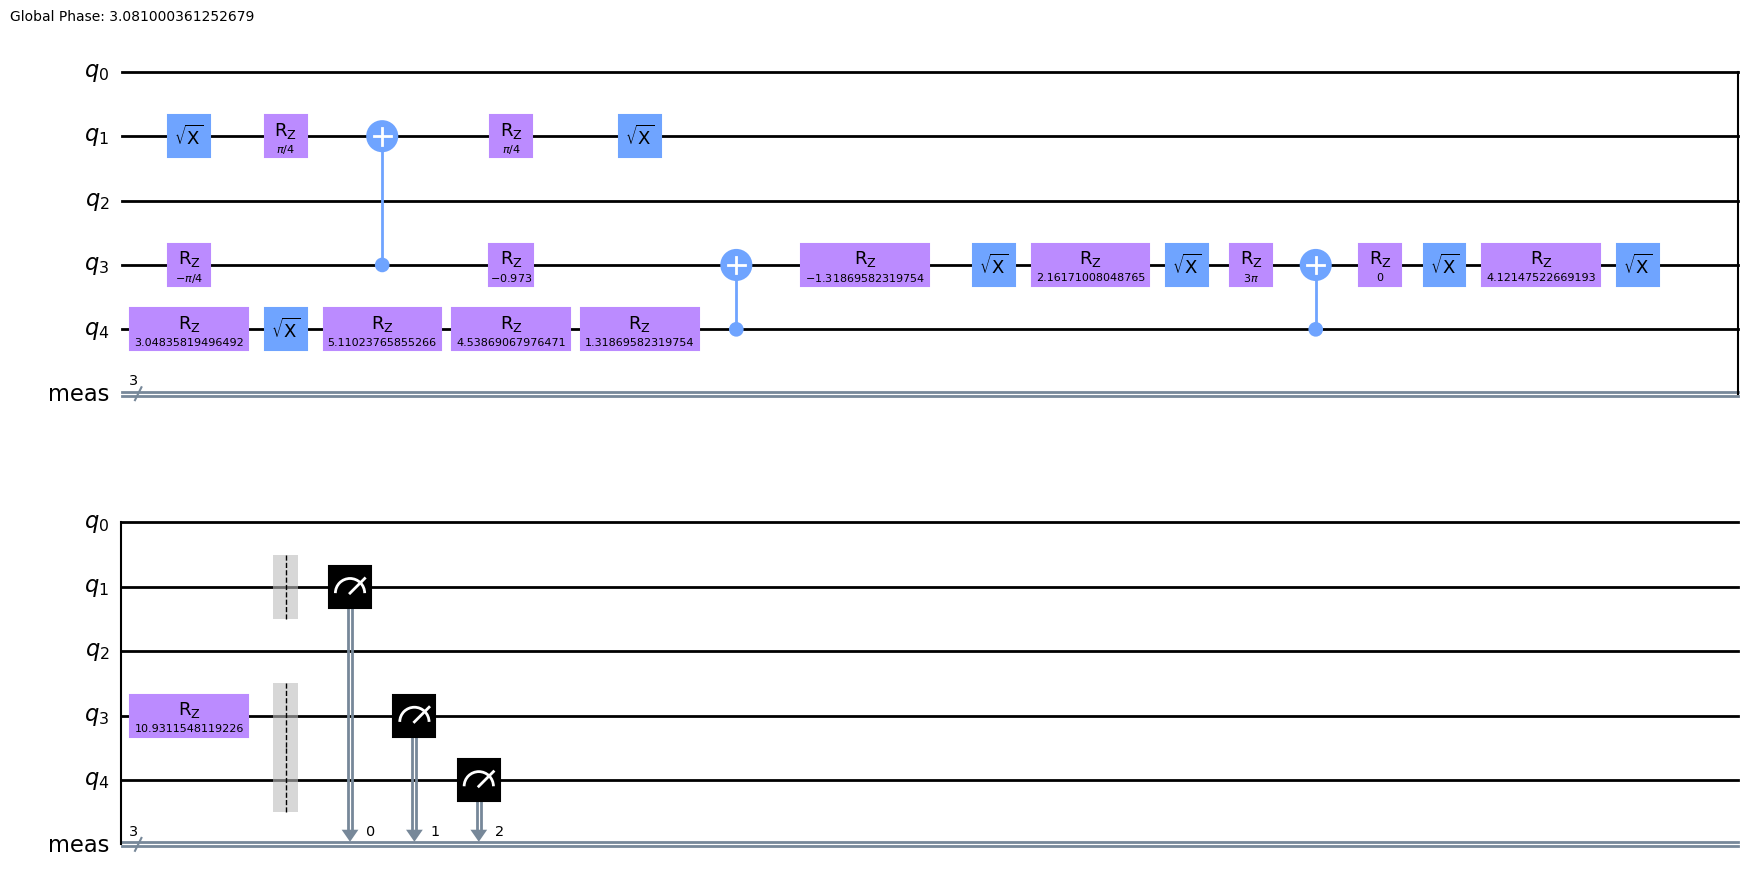

Circuit state after running <qiskit.transpiler.passes.scheduling.padding.dynamical_decoupling.PadDynamicalDecoupling object at 0x7f8be47c9660>:


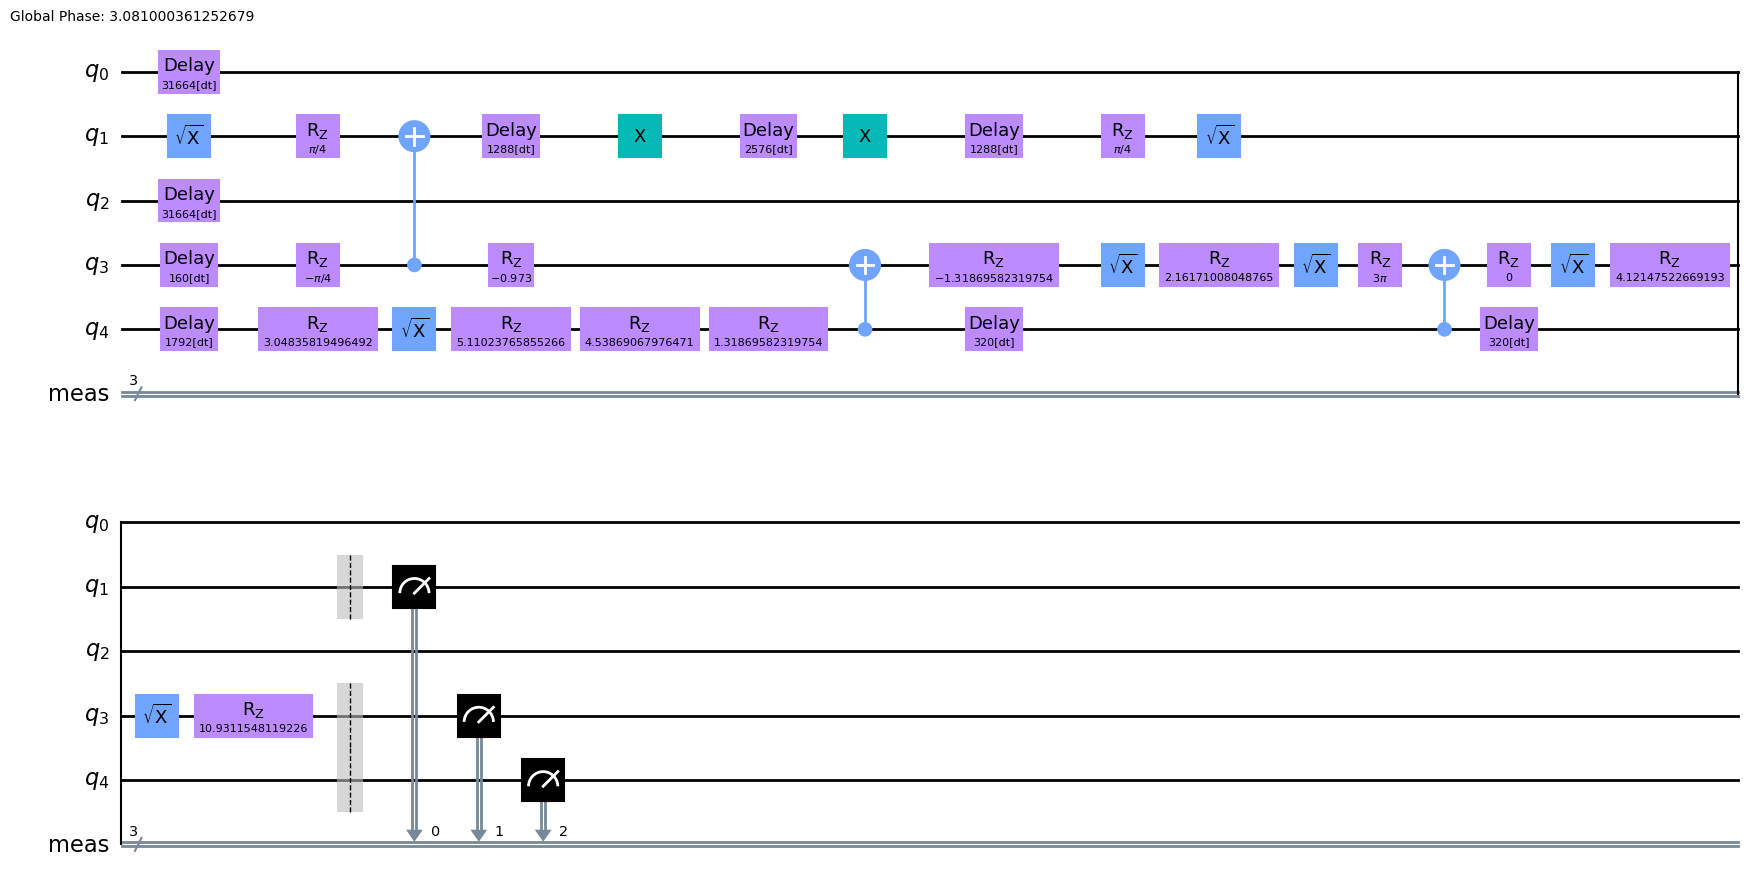

In [22]:
from qiskit.converters import dag_to_circuit
def callback(**kwargs):
    intermediate_circuit = dag_to_circuit(kwargs['dag'])
    intermediate_circuit.name = f"Circuit state after running {kwargs['pass_']}:"
    print(intermediate_circuit.name)
    display(intermediate_circuit.draw('mpl'))

pm.run(qc, callback=callback)

# Transpiler plugins

Besides having options to manually construct compilation pipelines to build Qiskit provides several plugin interfaces than enable external packages to provide extra methods that add extra options. There are currently three interfaces for doing this:

1. Stage plugins
2. Unitary Synthesis plugins
3. High level synthesis plugins

## Stage plugins

Building off the `StagedPassManager` is the introduction of external plugins for `transpile()` (and by extension `generate_preset_pass_manager()`). Since the stages are defined points in the execution of a compilation pipeline an external package can now provide alternative implenentations that can be used for these stages. The `*_method` keyword arguments on `transpile()` are used to specify which plugin to use.

You can see the details on writing a plugin in the documentation here:

https://qiskit.org/documentation/apidoc/transpiler_plugins.html

In [23]:
# pip install git+https://github.com/qiskit-community/dsm-swap
from qiskit.transpiler.preset_passmanagers import plugin
plugin.list_stage_plugins("routing")

['basic', 'lookahead', 'none', 'sabre', 'stochastic', 'dsm']

In [24]:
# pip install git+https://github.com/mtreinish/vf2_partial_layout
plugin.list_stage_plugins("layout")

['vf2_partial']

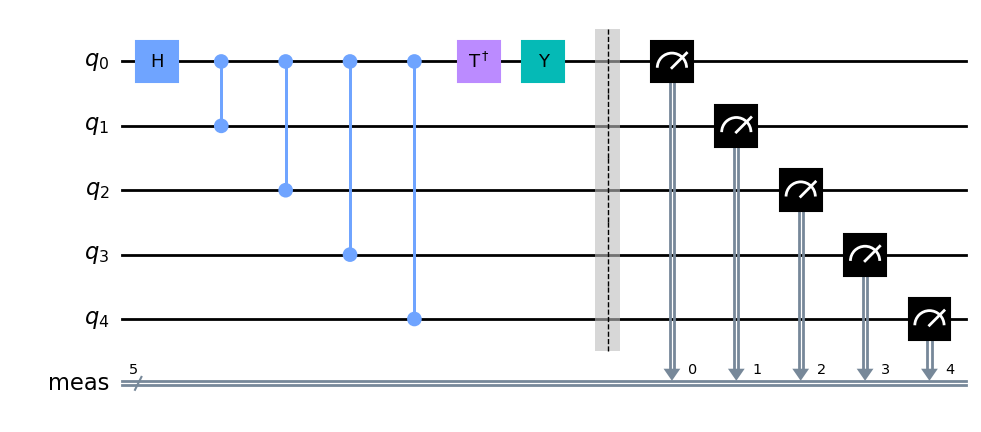

In [25]:
from qiskit import transpile

qc = QuantumCircuit(5)
qc.h(0)
qc.cz(0, 1)
qc.cz(0, 2)
qc.cz(0, 3)
qc.cz(0, 4)
qc.tdg(0)
qc.y(0)
qc.measure_all()
qc.draw('mpl')

/home/computertreker/Presentations/quantum_compiler_workshop/release/lib/python3.10/site-packages/dsm_swap/swapmatic.py:144: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return reduce(torch.sparse.mm, m) if compose else list(m)


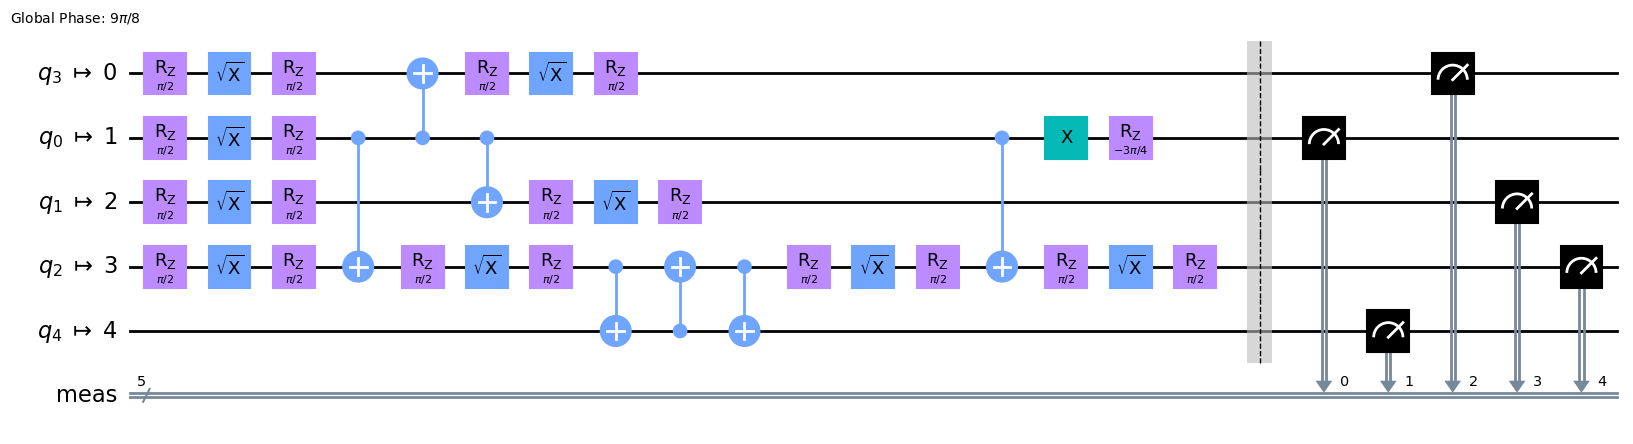

In [26]:
# Use external plugin for layout and routing:
transpile(qc, backend, layout_method='vf2_partial', routing_method="dsm").draw('mpl')

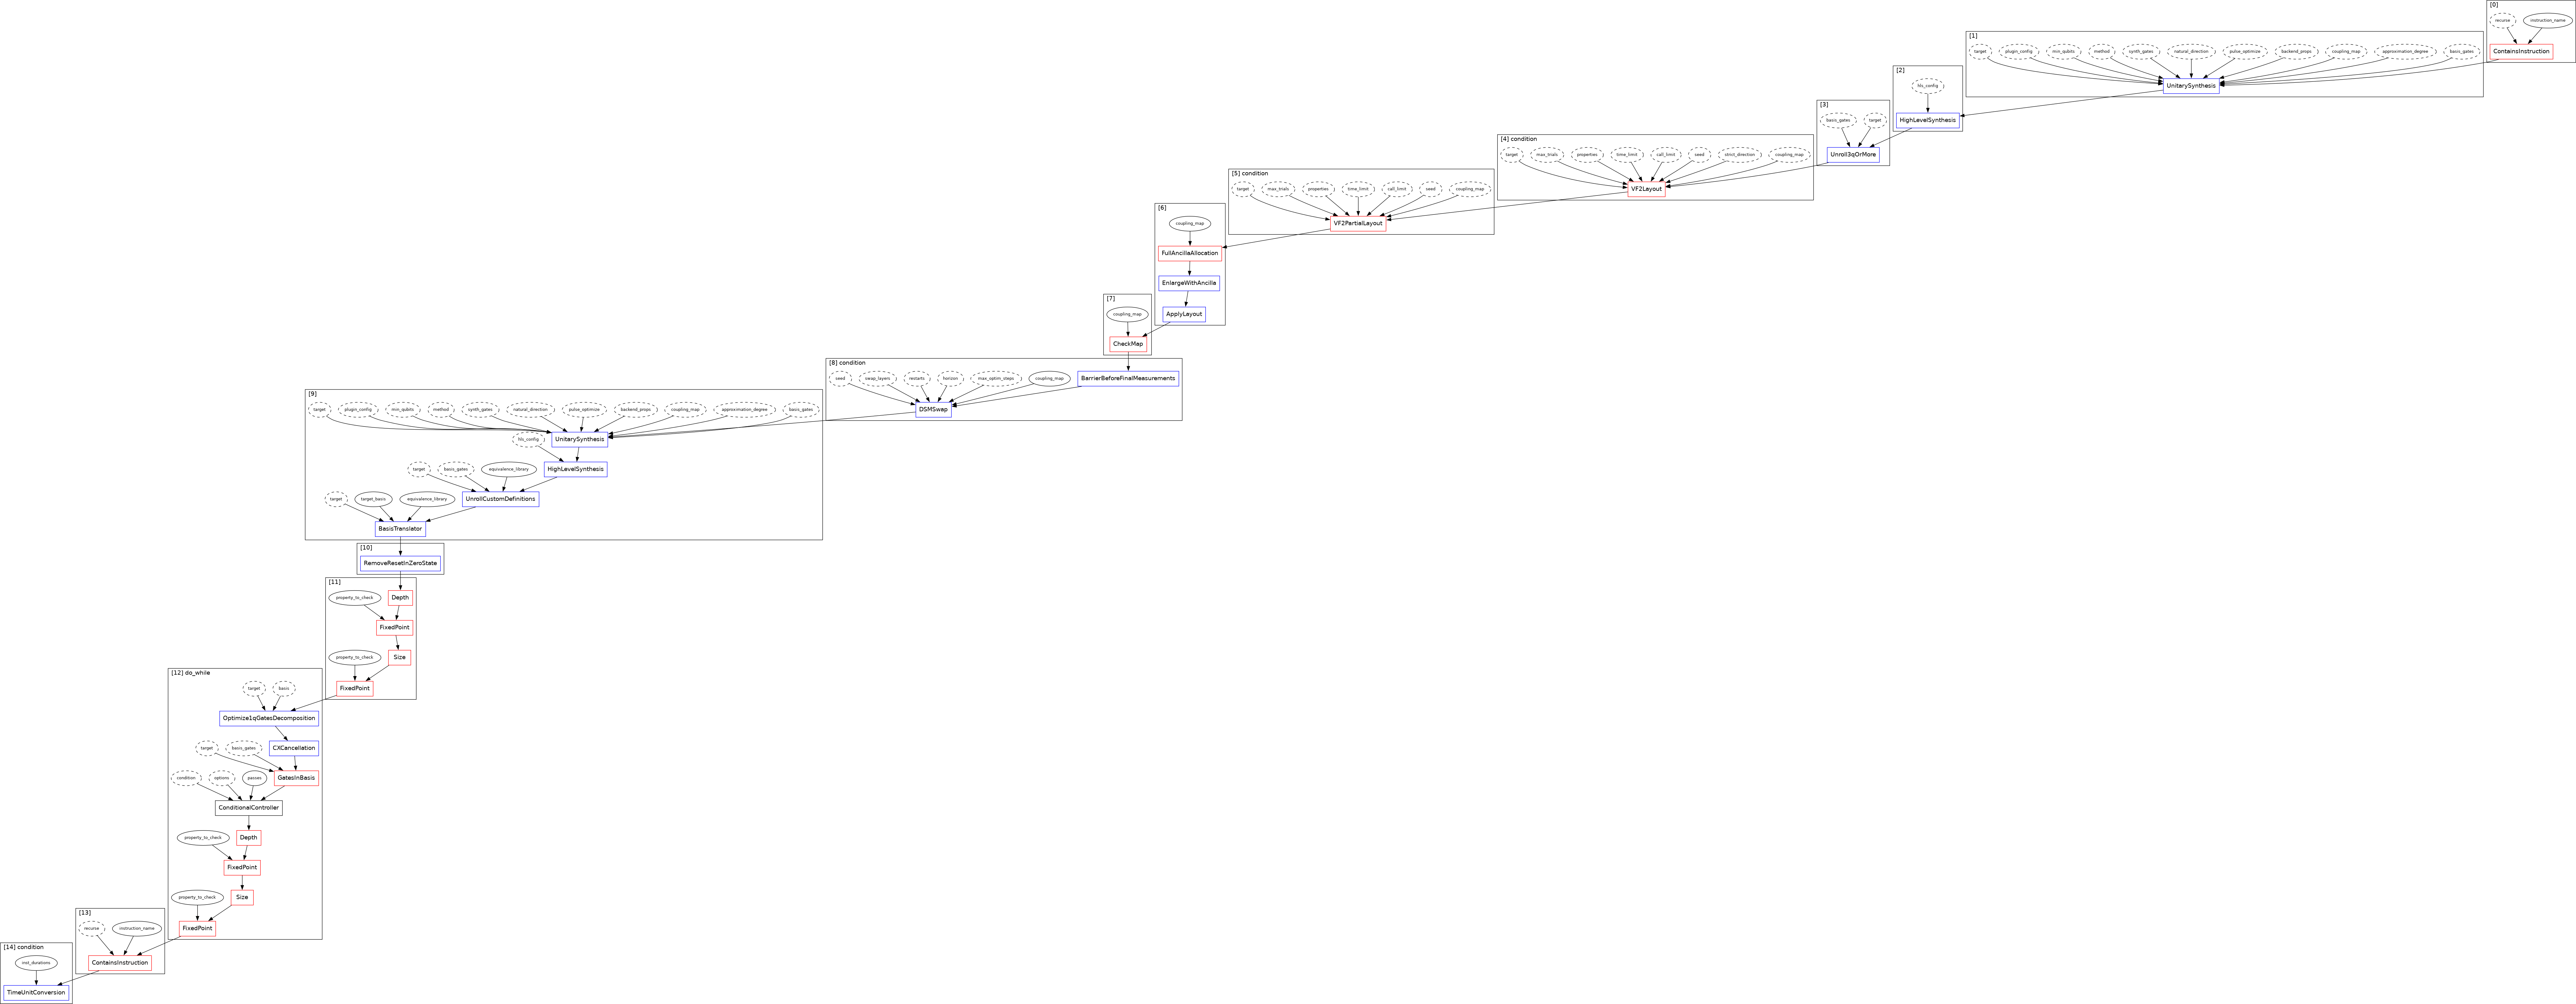

In [27]:
pm_with_plugins = generate_preset_pass_manager(1, backend, layout_method='vf2_partial', routing_method="dsm")
pm_with_plugins.draw('mpl')

### Backend Default Plugins

One special case of where plugins are potentially used already is with backends. If a backend has custom compilation requirements that adressable with the current Qiskit transpiler backends can specify alternate **default** compilation methods when they're targeted.

For example the `qiskit-ibm-provider` package includes several custom stage plugins. Then 
the backends from `qiskit-ibm-provider` use this feature to set an alternative default for the `translation` stage which adds an extra pass before the typical `translator` default stage.

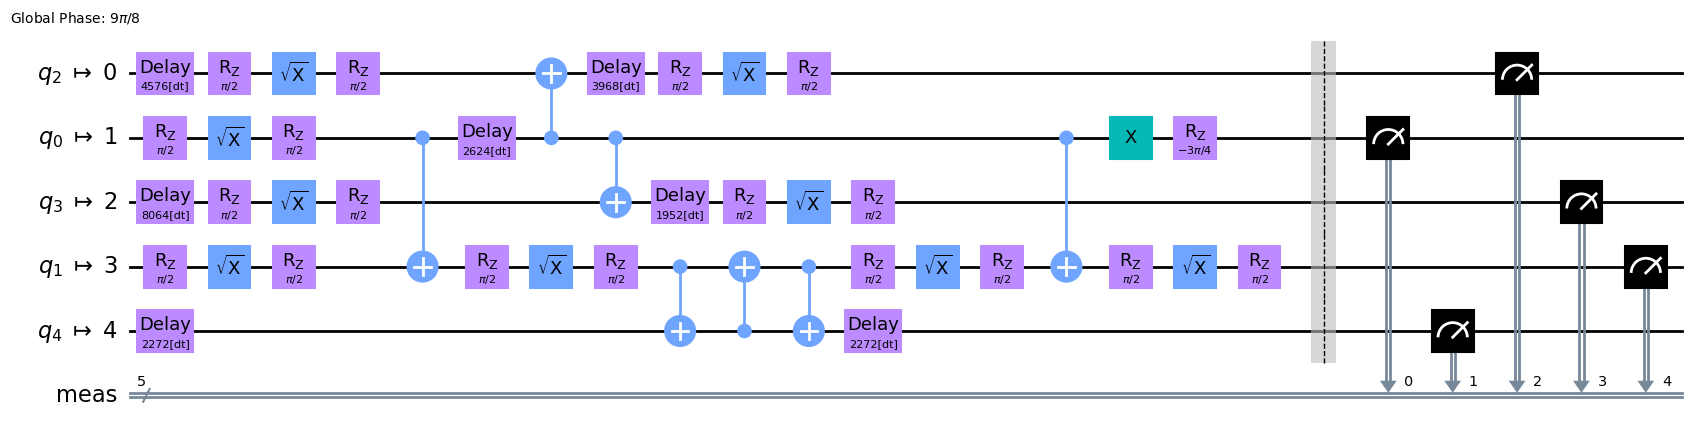

In [28]:
def plugin_fn(*args):
    return "alap"

# Set default value of scheduling_method to "alap"
backend.get_scheduling_stage_plugin = plugin_fn
res = transpile(qc, backend)
res.draw('mpl')

### Unitary Synthesis Plugins

When a circuit contains a `UnitaryGate` (a gate modeled solely by its unitary matrix) the unitary synthesis plugin interface allows external packages to provide alternative methods for synthesizing that unitary.

https://qiskit.org/documentation/apidoc/transpiler_synthesis_plugins.html#unitary-synthesis-plugins

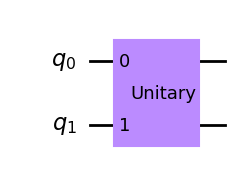

In [29]:
from qiskit.quantum_info import random_unitary

matrix = random_unitary(4)
qc = QuantumCircuit(2)
qc.unitary(matrix, [0, 1])
qc.draw('mpl')

In [30]:
from qiskit.transpiler.passes.synthesis.plugin import unitary_synthesis_plugin_names

unitary_synthesis_plugin_names()

['aqc', 'default', 'sk']

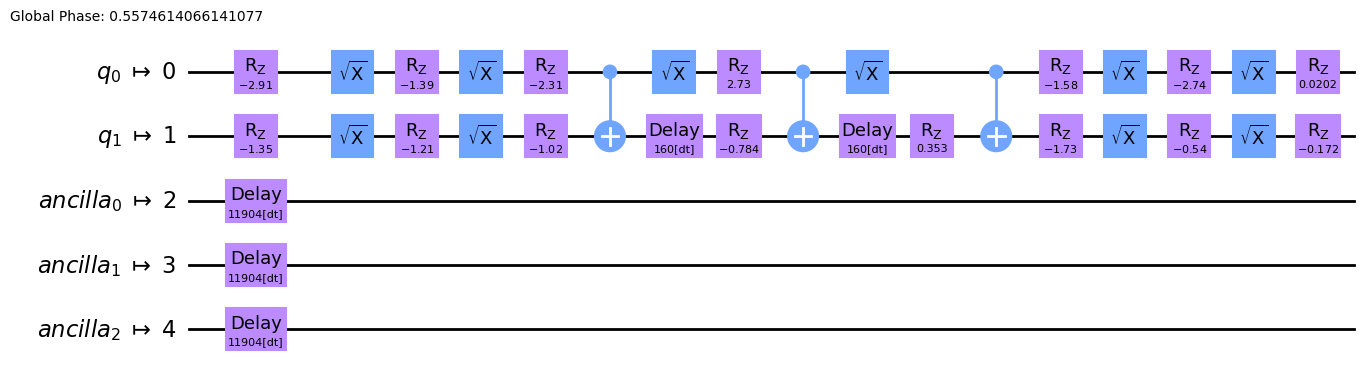

In [31]:
aqc_config = {"networkx_layout": "cart", "connectivity_type": "star"}
transpile(qc, backend, unitary_synthesis_method='aqc', unitary_synthesis_plugin_config=aqc_config).draw('mpl')

### High Level Synthesis Plugins

This new interface lets external packages provide synthesis methods for arbitrary higher level circuit objects. These higher level objects are typically mathematical representations of operations like Cliffords, linear functions, etc.

https://qiskit.org/documentation/apidoc/transpiler_synthesis_plugins.html#high-level-synthesis-plugins

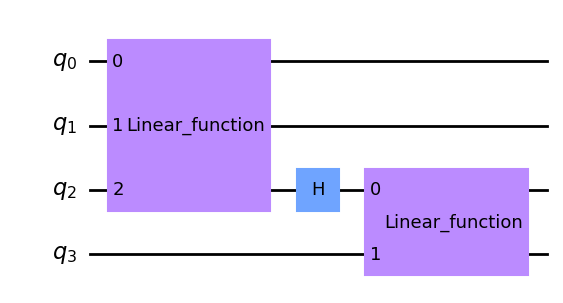

In [32]:
from qiskit.circuit.library import LinearFunction

qc1 = QuantumCircuit(3)
qc1.swap(0, 2)
qc1.cx(0, 1)
qc1.swap(1, 2)
lf1 = LinearFunction(qc1)
qc2 = QuantumCircuit(2)
qc2.swap(0, 1)
qc2.cx(1, 0)
qc2.swap(0, 1)
lf2 = LinearFunction(qc2)

qc = QuantumCircuit(4)
qc.append(lf1, [0, 1, 2])
qc.h(2)
qc.append(lf2, [2, 3])
qc.draw("mpl")

Running KutinSynthesisPlugin
Running KutinSynthesisPlugin


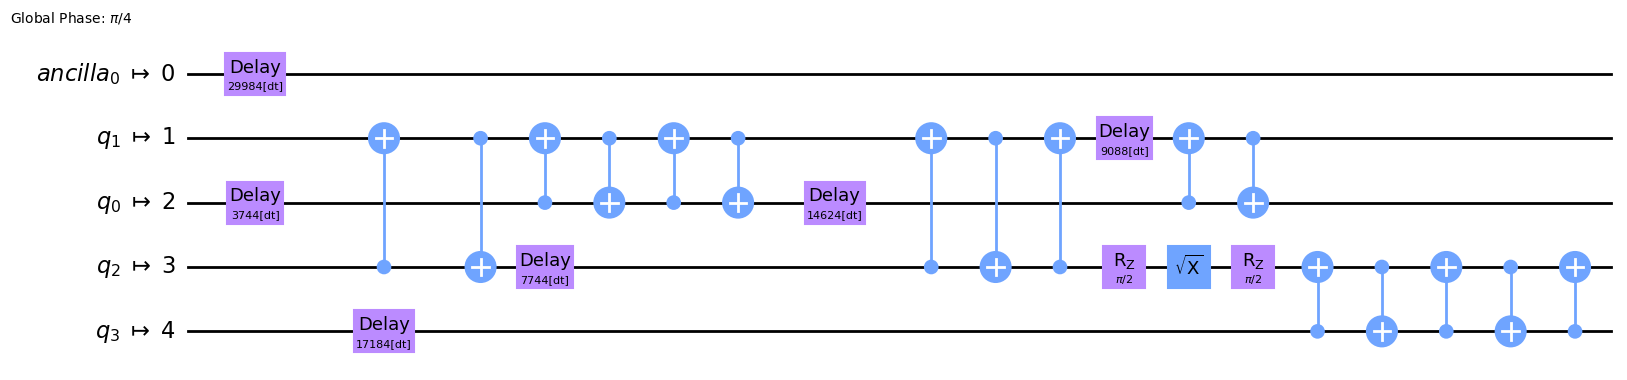

In [33]:
# pip install kutin-synthesis-plugin-for-qiskit
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig

hls_config = HLSConfig(linear_function=[("kutin", {})])
transpile(qc, backend, hls_config=hls_config).draw("mpl")